In [ ]:
from google.colab import drive
import json

# 挂载你的 Google Drive
drive.mount('/content/drive')


# ✅ 只改这两个参数：根据你要处理的问题编号区间修改
start_index = 700
end_index   = 731
range_tag   = f"{start_index}-{end_index}"

# ✅ 项目根目录（挂载后在 Colab 里的路径）
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"

# ✅ 你的 logits JSON 路径
# LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}.json"

# ✅ 你的 error index JSON 路径（注意文件名后缀对齐）
# ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_index/{range_tag}_sentence_with_index.json"
LOGITS_PATH       = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH  = f"{BASE_PATH}/output/error_index/{range_tag}_hidden_index.json"


# 读取 logits 数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)

# 读取错误索引数据
with open(ERROR_INDEX_PATH, "r") as f:
    error_index_data = json.load(f)


Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

def adaptive_kde(x, y, grid, pilot_bw='scott', alpha=0.5):
    """
    x: 每个 step 的索引（0,1,2,...）
    y: 对应 step 的熵值列表
    grid: 平滑后要评估的横坐标点集合
    pilot_bw: 初始带宽规则 ('scott' 或 'silverman' 或数值)
    alpha: Abramson 校正指数，0.5 表示开方校正
    """
    # 1) pilot KDE：用带权重 y 的 x 值估计初始密度 f_pilot(x)
    kde_pilot = gaussian_kde(x, bw_method=pilot_bw, weights=y)
    f_pilot   = kde_pilot(x)
    # 取几何平均 g
    g = np.exp(np.mean(np.log(f_pilot + 1e-12)))

    # 2) 计算每个点的本地带宽 h_i
    h0 = kde_pilot.factor
    h_i = h0 * (g / (f_pilot + 1e-12))**alpha

    # 3) 在 grid 上累加各高斯核
    pdf = np.zeros_like(grid)
    for xi, yi, hi in zip(x, y, h_i):
        pdf += yi * np.exp(-0.5*((grid - xi)/hi)**2) / (hi * np.sqrt(2*np.pi))
    # 归一化
    pdf /= pdf.sum() * (grid[1] - grid[0])
    return pdf


In [ ]:
print("logits_data keys:", list(logits_data.keys())[:30])
print("error_index_data keys:", list(error_index_data.keys())[:30])


logits_data keys: ['q_700', 'q_701', 'q_702', 'q_703', 'q_704', 'q_705', 'q_706', 'q_707', 'q_708', 'q_709', 'q_710', 'q_711', 'q_712', 'q_713', 'q_714', 'q_715', 'q_716', 'q_717', 'q_718', 'q_719', 'q_720', 'q_721', 'q_722', 'q_723', 'q_724', 'q_725', 'q_726', 'q_727', 'q_728', 'q_729']
error_index_data keys: ['q_700', 'q_701', 'q_702', 'q_704', 'q_707', 'q_708', 'q_709', 'q_710', 'q_711', 'q_714', 'q_716', 'q_717', 'q_718', 'q_719', 'q_720', 'q_723', 'q_724', 'q_726', 'q_727', 'q_729', 'q_730']


In [ ]:

# ✅ 所有可能配对的 question-sampling 对列表
paired_qid_sids = []

for qid, sid_dict in error_index_data.items():
    all_sids = {"sampling0", "sampling1", "sampling2"}
    error_sids = set(sid_dict.keys())
    correct_sids = all_sids - error_sids

    # 至少有一对正负组合
    if error_sids and correct_sids:
        for err_sid in error_sids:
            for cor_sid in correct_sids:
                paired_qid_sids.append((qid, err_sid, cor_sid))  # (qid, neg_sid, pos_sid)

# ✅ 打印所有有效的 (qid, neg_sid, pos_sid) 配对
print(f"✅ 共找到 {len(paired_qid_sids)} 个正负样本配对:")
for item in paired_qid_sids:
    print(item)


✅ 共找到 26 个正负样本配对:
('q_702', 'sampling2', 'sampling1')
('q_702', 'sampling2', 'sampling0')
('q_704', 'sampling1', 'sampling2')
('q_704', 'sampling0', 'sampling2')
('q_707', 'sampling0', 'sampling1')
('q_707', 'sampling0', 'sampling2')
('q_710', 'sampling1', 'sampling2')
('q_710', 'sampling1', 'sampling0')
('q_711', 'sampling2', 'sampling1')
('q_711', 'sampling2', 'sampling0')
('q_714', 'sampling0', 'sampling1')
('q_714', 'sampling0', 'sampling2')
('q_717', 'sampling0', 'sampling1')
('q_717', 'sampling0', 'sampling2')
('q_718', 'sampling1', 'sampling0')
('q_718', 'sampling2', 'sampling0')
('q_723', 'sampling1', 'sampling2')
('q_723', 'sampling1', 'sampling0')
('q_724', 'sampling1', 'sampling2')
('q_724', 'sampling1', 'sampling0')
('q_727', 'sampling1', 'sampling0')
('q_727', 'sampling2', 'sampling0')
('q_729', 'sampling2', 'sampling1')
('q_729', 'sampling2', 'sampling0')
('q_730', 'sampling0', 'sampling1')
('q_730', 'sampling0', 'sampling2')


In [ ]:
OUTPUT_DIR = f"{BASE_PATH}/output/paired_entropy_kde_plots_index"
os.makedirs(OUTPUT_DIR, exist_ok=True)
def plot_entropy_with_indices(qid, neg_sid, pos_sid):
    if qid not in error_index_data or qid not in logits_data:
        return
    if neg_sid not in error_index_data[qid] or neg_sid not in logits_data[qid]:
        return
    if pos_sid not in logits_data[qid]:
        return

    neg_probs = logits_data[qid][neg_sid]["token_probs"]
    pos_probs = logits_data[qid][pos_sid]["token_probs"]

    entropy_neg = [tok["topk_info"]["entropy"] for tok in neg_probs]
    entropy_pos = [tok["topk_info"]["entropy"] for tok in pos_probs]
    idx_neg = list(range(len(entropy_neg)))
    idx_pos = list(range(len(entropy_pos)))

    first_error_idx = error_index_data[qid][neg_sid]["first_error_token_index"]
    last_error_idx = error_index_data[qid][neg_sid]["last_error_token_index"]

    plt.figure(figsize=(12, 5))
    plt.plot(idx_neg, entropy_neg, color='red', label=f"{neg_sid} (error)")
    plt.plot(idx_pos, entropy_pos, color='green', label=f"{pos_sid} (correct)")
    plt.axvline(first_error_idx, color='red', linestyle='--', label="First Error Token")
    plt.axvline(last_error_idx, color='red', linestyle='--', alpha=0.3, label="Last Error Token")
    plt.scatter(
        [first_error_idx], [entropy_neg[first_error_idx]],
        color='red', marker='x', s=100, label="Error Start"
    )
    plt.title(f"Token Entropy by Index — {qid} | {neg_sid} vs {pos_sid}")
    plt.xlabel("Token Index")
    plt.ylabel("Entropy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fname = f"{qid}_{neg_sid}_vs_{pos_sid}_indexplot.png"
    plt.savefig(os.path.join(OUTPUT_DIR, fname))
    plt.close()

# ✅ 批量绘图
for qid, neg_sid, pos_sid in paired_qid_sids:
    try:
        plot_entropy_with_indices(qid, neg_sid, pos_sid)
    except Exception as e:
        print(f"❌ 跳过 {qid} | {neg_sid} vs {pos_sid}：{e}")

print(f"✅ 全部图像已保存至：{OUTPUT_DIR}")

✅ 全部图像已保存至：/content/drive/MyDrive/Cluster-proj/output/paired_entropy_kde_plots_index


In [ ]:
OUTPUT_DIR = f"{BASE_PATH}/output/paired_entropy_kde_plots_index2"
os.makedirs(OUTPUT_DIR, exist_ok=True)
def plot_entropy_kde_with_error_tokens(qid, neg_sid, pos_sid):
    neg_probs = logits_data[qid][neg_sid]["token_probs"]
    pos_probs = logits_data[qid][pos_sid]["token_probs"]

    entropy_neg = [tok["topk_info"]["entropy"] for tok in neg_probs]
    entropy_pos = [tok["topk_info"]["entropy"] for tok in pos_probs]

    # 错误 token 的熵点
    first = error_index_data[qid][neg_sid]["first_error_token_index"]
    last = error_index_data[qid][neg_sid]["last_error_token_index"]
    error_entropy = [entropy_neg[i] for i in range(first, last + 1)]

    # KDE 曲线
    kde_neg = gaussian_kde(entropy_neg, bw_method='silverman')
    kde_pos = gaussian_kde(entropy_pos, bw_method='silverman')

    xs = np.linspace(min(entropy_neg + entropy_pos) - 0.1, max(entropy_neg + entropy_pos) + 0.1, 200)

    # 画图
    plt.figure(figsize=(10, 6))
    plt.plot(xs, kde_neg(xs), color='red', label=f"{neg_sid} (error)")
    plt.plot(xs, kde_pos(xs), color='green', label=f"{pos_sid} (correct)")
    plt.axvline(np.mean(error_entropy), color='red', linestyle='--', label="Mean Error Token Entropy")
    plt.scatter(error_entropy, [0]*len(error_entropy), color='red', marker='x', s=80, label="Error Tokens")

    plt.title(f"KDE Entropy + Error Tokens — {qid} | {neg_sid} vs {pos_sid}")
    plt.xlabel("Entropy")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fname = f"{qid}_{neg_sid}_vs_{pos_sid}_kde_error.png"
    plt.savefig(os.path.join(OUTPUT_DIR, fname))
    plt.close()

# ✅ 批量处理
for qid, neg_sid, pos_sid in paired_qid_sids:
    try:
        plot_entropy_kde_with_error_tokens(qid, neg_sid, pos_sid)
    except Exception as e:
        print(f"❌ 跳过 {qid} {neg_sid} vs {pos_sid} — {e}")

print(f"🎯 所有 KDE + 错误熵标注图已保存至：{OUTPUT_DIR}")

🎯 所有 KDE + 错误熵标注图已保存至：/content/drive/MyDrive/Cluster-proj/output/paired_entropy_kde_plots_index2


In [2]:
# -*- coding: utf-8 -*-
"""
Fix Region vs Error Region Comparison Analysis
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from scipy.stats import gaussian_kde
import gc
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

# ✅ 配置路径参数
start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"

# 输入文件路径
LOGITS_JSONL_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}.jsonl"
ERROR_FIX_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"

# ✅ 检查JSONL文件是否存在
if not os.path.exists(LOGITS_JSONL_PATH):
    print(f"⚠️ JSONL file not found: {LOGITS_JSONL_PATH}")
    print("Converting JSON to JSONL first...")

    # 快速转换JSON到JSONL
    json_path = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}.json"

    def convert_json_to_jsonl_chunked(json_path, jsonl_path, chunk_size=10):
        """分块转换JSON到JSONL以节省内存"""
        print(f"🔄 Converting {json_path} to JSONL...")

        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        total_items = len(data)
        print(f"📊 Total items: {total_items}")

        with open(jsonl_path, 'w', encoding='utf-8') as f:
            for i, (qid, sample) in enumerate(data.items()):
                line_data = {"qid": qid, "data": sample}
                f.write(json.dumps(line_data, ensure_ascii=False) + '\n')

                if (i + 1) % chunk_size == 0:
                    print(f"📈 Converted {i + 1}/{total_items}")
                    f.flush()  # 强制写入磁盘

        # 清理内存
        del data
        gc.collect()
        print(f"✅ Conversion complete: {jsonl_path}")

    convert_json_to_jsonl_chunked(json_path, LOGITS_JSONL_PATH)

# ✅ 加载错误修复索引数据
print("📂 Loading error-fix index data...")
if os.path.exists(ERROR_FIX_INDEX_PATH):
    with open(ERROR_FIX_INDEX_PATH, "r") as f:
        error_fix_data = json.load(f)
    print(f"✅ Loaded error-fix data: {len(error_fix_data)} questions")
else:
    print(f"⚠️ Error-fix index file not found: {ERROR_FIX_INDEX_PATH}")
    print("Please run the error analysis script first!")
    exit()

# ✅ 输出路径
OUTPUT_DIR = f"{BASE_PATH}/output/kde_fix_error_region_comparison"
KDE_OUTPUT_DIR = f"{BASE_PATH}/output/kde_fix_error_region"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(KDE_OUTPUT_DIR, exist_ok=True)

# ✅ 流式加载单个样本的logits数据
def load_sample_logits(qid, sampling_ids):
    """
    从JSONL文件中流式加载指定样本的logits数据
    """
    sample_data = {}

    with open(LOGITS_JSONL_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            line_data = json.loads(line.strip())
            if line_data["qid"] == qid:
                data = line_data["data"]
                # 只提取需要的sampling数据
                for sid in sampling_ids:
                    if sid in data:
                        sample_data[sid] = data[sid]
                break

    return sample_data

# ✅ 提取区间熵值的函数
def extract_region_entropy(token_probs, begin_idx, end_idx):
    """
    提取指定区间的熵值
    """
    if begin_idx < 0 or end_idx < 0 or begin_idx >= len(token_probs) or end_idx >= len(token_probs):
        return []

    entropy_values = []
    for i in range(begin_idx, min(end_idx + 1, len(token_probs))):
        entropy_values.append(token_probs[i]["topk_info"]["entropy"])

    return entropy_values

# ✅ 提取区间tokens的函数
def extract_region_tokens(token_probs, begin_idx, end_idx):
    """
    提取指定区间的tokens
    """
    if begin_idx < 0 or end_idx < 0 or begin_idx >= len(token_probs) or end_idx >= len(token_probs):
        return []

    tokens = []
    for i in range(begin_idx, min(end_idx + 1, len(token_probs))):
        tokens.append(token_probs[i]["token"])

    return tokens

# ✅ 绘制Fix Region vs Error Region对比分析
def plot_fix_error_region_comparison(qid, neg_sid, pos_sid, analysis_data, save_dir):
    """
    专门对比Fix Region和Error Region的详细分析
    """
    try:
        # 流式加载所需的样本数据
        sample_logits = load_sample_logits(qid, [neg_sid, pos_sid])

        if neg_sid not in sample_logits or pos_sid not in sample_logits:
            print(f"⚠️ Missing logits: {qid} | {neg_sid} / {pos_sid}")
            return

        neg_probs = sample_logits[neg_sid]["token_probs"]
        pos_probs = sample_logits[pos_sid]["token_probs"]

        # 获取区间位置
        error_begin = analysis_data.get("error_token_begin_index", -1)
        error_end = analysis_data.get("error_token_end_index", -1)
        fix_begin = analysis_data.get("fix_token_begin_index", -1)
        fix_end = analysis_data.get("fix_token_end_index", -1)

        # 提取区间熵值和tokens
        error_entropy = extract_region_entropy(neg_probs, error_begin, error_end)
        fix_entropy = extract_region_entropy(pos_probs, fix_begin, fix_end)
        error_tokens = extract_region_tokens(neg_probs, error_begin, error_end)
        fix_tokens = extract_region_tokens(pos_probs, fix_begin, fix_end)

        if not error_entropy or not fix_entropy:
            print(f"⚠️ Empty regions for {qid}")
            return

        # ✅ 创建对比图 (2x2 layout)
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # 子图1: Error Region详细分析
        error_indices = np.arange(error_begin, error_begin + len(error_entropy))
        axs[0, 0].plot(error_indices, error_entropy, 'ro-', linewidth=2, markersize=8, label="Error Region Entropy")
        axs[0, 0].set_title(f"Error Region Analysis ({neg_sid})\nTokens: {error_begin}-{error_end}")
        axs[0, 0].set_xlabel("Token Index")
        axs[0, 0].set_ylabel("Entropy")
        axs[0, 0].grid(True, alpha=0.3)
        axs[0, 0].legend()

        # 添加token标注
        for i, (idx, token) in enumerate(zip(error_indices, error_tokens)):
            if i % max(1, len(error_tokens) // 8) == 0:  # 限制标注数量
                axs[0, 0].annotate(f"{token[:8]}", (idx, error_entropy[i]),
                                 textcoords="offset points", xytext=(0,15),
                                 ha='center', fontsize=8, rotation=45)

        # 子图2: Fix Region详细分析
        fix_indices = np.arange(fix_begin, fix_begin + len(fix_entropy))
        axs[0, 1].plot(fix_indices, fix_entropy, 'go-', linewidth=2, markersize=8, label="Fix Region Entropy")
        axs[0, 1].set_title(f"Fix Region Analysis ({pos_sid})\nTokens: {fix_begin}-{fix_end}")
        axs[0, 1].set_xlabel("Token Index")
        axs[0, 1].set_ylabel("Entropy")
        axs[0, 1].grid(True, alpha=0.3)
        axs[0, 1].legend()

        # 添加token标注
        for i, (idx, token) in enumerate(zip(fix_indices, fix_tokens)):
            if i % max(1, len(fix_tokens) // 8) == 0:  # 限制标注数量
                axs[0, 1].annotate(f"{token[:8]}", (idx, fix_entropy[i]),
                                 textcoords="offset points", xytext=(0,15),
                                 ha='center', fontsize=8, rotation=45)

        # 子图3: 直接对比 (对齐长度)
        max_len = max(len(error_entropy), len(fix_entropy))
        normalized_pos = np.arange(max_len)

        # 填充较短的序列
        error_aligned = error_entropy + [np.nan] * (max_len - len(error_entropy))
        fix_aligned = fix_entropy + [np.nan] * (max_len - len(fix_entropy))

        axs[1, 0].plot(normalized_pos[:len(error_entropy)], error_entropy, 'ro-',
                      linewidth=2, markersize=6, label="Error Region", alpha=0.8)
        axs[1, 0].plot(normalized_pos[:len(fix_entropy)], fix_entropy, 'go-',
                      linewidth=2, markersize=6, label="Fix Region", alpha=0.8)

        axs[1, 0].set_title("Direct Region Comparison")
        axs[1, 0].set_xlabel("Relative Position in Region")
        axs[1, 0].set_ylabel("Entropy")
        axs[1, 0].legend()
        axs[1, 0].grid(True, alpha=0.3)

        # 子图4: 统计对比
        error_stats = {
            'mean': np.mean(error_entropy),
            'std': np.std(error_entropy),
            'min': np.min(error_entropy),
            'max': np.max(error_entropy)
        }
        fix_stats = {
            'mean': np.mean(fix_entropy),
            'std': np.std(fix_entropy),
            'min': np.min(fix_entropy),
            'max': np.max(fix_entropy)
        }

        categories = ['Mean', 'Std', 'Min', 'Max']
        error_values = [error_stats['mean'], error_stats['std'], error_stats['min'], error_stats['max']]
        fix_values = [fix_stats['mean'], fix_stats['std'], fix_stats['min'], fix_stats['max']]

        x = np.arange(len(categories))
        width = 0.35

        axs[1, 1].bar(x - width/2, error_values, width, label='Error Region', color='red', alpha=0.7)
        axs[1, 1].bar(x + width/2, fix_values, width, label='Fix Region', color='green', alpha=0.7)

        axs[1, 1].set_title("Statistical Comparison")
        axs[1, 1].set_xlabel("Statistics")
        axs[1, 1].set_ylabel("Entropy Value")
        axs[1, 1].set_xticks(x)
        axs[1, 1].set_xticklabels(categories)
        axs[1, 1].legend()
        axs[1, 1].grid(True, alpha=0.3)

        # 添加数值标签
        for i, (err_val, fix_val) in enumerate(zip(error_values, fix_values)):
            axs[1, 1].text(i - width/2, err_val + 0.01, f'{err_val:.3f}',
                          ha='center', va='bottom', fontsize=8)
            axs[1, 1].text(i + width/2, fix_val + 0.01, f'{fix_val:.3f}',
                          ha='center', va='bottom', fontsize=8)

        # 设置整体标题
        fig.suptitle(f"Fix vs Error Region Analysis: {qid} | {neg_sid} vs {pos_sid}",
                    fontsize=16, y=0.98)
        plt.tight_layout()

        # 保存图片
        fname = f"{qid}_{neg_sid}_vs_{pos_sid}_fix_error_comparison.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches='tight')
        plt.close()

        # 清理内存
        del sample_logits, neg_probs, pos_probs
        gc.collect()

        print(f"✅ Saved comparison: {fname}")

        # 返回统计信息用于后续分析
        return {
            'qid': qid,
            'error_stats': error_stats,
            'fix_stats': fix_stats,
            'error_length': len(error_entropy),
            'fix_length': len(fix_entropy)
        }

    except Exception as e:
        print(f"❌ Comparison failed {qid} | {neg_sid} vs {pos_sid}: {e}")
        return None

# ✅ KDE密度对比分析
def plot_kde_region_comparison(qid, neg_sid, pos_sid, analysis_data, save_dir):
    """
    使用KDE对比Error Region和Fix Region的熵分布
    """
    try:
        # 流式加载所需的样本数据
        sample_logits = load_sample_logits(qid, [neg_sid, pos_sid])

        if neg_sid not in sample_logits or pos_sid not in sample_logits:
            return

        neg_probs = sample_logits[neg_sid]["token_probs"]
        pos_probs = sample_logits[pos_sid]["token_probs"]

        # 获取区间位置
        error_begin = analysis_data.get("error_token_begin_index", -1)
        error_end = analysis_data.get("error_token_end_index", -1)
        fix_begin = analysis_data.get("fix_token_begin_index", -1)
        fix_end = analysis_data.get("fix_token_end_index", -1)

        # 提取区间熵值
        error_entropy = extract_region_entropy(neg_probs, error_begin, error_end)
        fix_entropy = extract_region_entropy(pos_probs, fix_begin, fix_end)

        if not error_entropy or not fix_entropy:
            return

        # 计算KDE
        if len(error_entropy) > 1:
            kde_error = gaussian_kde(error_entropy, bw_method='silverman')
        if len(fix_entropy) > 1:
            kde_fix = gaussian_kde(fix_entropy, bw_method='silverman')

        # 创建评估网格
        all_entropy = error_entropy + fix_entropy
        x_min, x_max = min(all_entropy), max(all_entropy)
        x_range = x_max - x_min
        xs = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 200)

        # ✅ 创建KDE对比图
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # 子图1: KDE密度对比
        if len(error_entropy) > 1:
            axs[0].plot(xs, kde_error(xs), color='red', linewidth=3, label='Error Region KDE', alpha=0.8)
        if len(fix_entropy) > 1:
            axs[0].plot(xs, kde_fix(xs), color='green', linewidth=3, label='Fix Region KDE', alpha=0.8)

        # 添加原始数据点
        axs[0].scatter(error_entropy, [0]*len(error_entropy), color='red',
                      marker='x', s=60, alpha=0.8, label='Error Region Points')
        axs[0].scatter(fix_entropy, [0]*len(fix_entropy), color='green',
                      marker='o', s=60, alpha=0.8, label='Fix Region Points')

        # 添加均值线
        axs[0].axvline(np.mean(error_entropy), color='red', linestyle='--',
                      alpha=0.7, label=f'Error Mean: {np.mean(error_entropy):.3f}')
        axs[0].axvline(np.mean(fix_entropy), color='green', linestyle='--',
                      alpha=0.7, label=f'Fix Mean: {np.mean(fix_entropy):.3f}')

        axs[0].set_title(f"KDE Density Comparison\n{qid}")
        axs[0].set_xlabel("Entropy")
        axs[0].set_ylabel("Density")
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)

        # 子图2: 箱线图对比
        box_data = [error_entropy, fix_entropy]
        box_labels = ['Error Region', 'Fix Region']
        colors = ['red', 'green']

        bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        # 添加原始数据点
        for i, (data, color) in enumerate(zip(box_data, colors)):
            y = np.random.normal(i+1, 0.04, size=len(data))
            axs[1].scatter(y, data, alpha=0.6, color=color, s=30)

        axs[1].set_title("Box Plot Comparison")
        axs[1].set_ylabel("Entropy")
        axs[1].grid(True, alpha=0.3)

        plt.tight_layout()

        # 保存图片
        fname = f"{qid}_{neg_sid}_vs_{pos_sid}_kde_region_comparison.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches='tight')
        plt.close()

        # 清理内存
        del sample_logits, neg_probs, pos_probs
        gc.collect()

        print(f"✅ Saved KDE comparison: {fname}")

    except Exception as e:
        print(f"❌ KDE comparison failed {qid}: {e}")

# ✅ 主处理循环
print("\n🚀 Starting Fix vs Error Region comparison analysis...")

# 统计信息
total_samples = 0
processed_count = 0
error_count = 0
all_stats = []

# 逐个处理样本
for qid, sample_data in error_fix_data.items():
    for neg_sid, analysis in sample_data.items():
        pos_sid = analysis.get("correct_sampling_id")
        if pos_sid:
            total_samples += 1

            try:
                print(f"🔍 Processing {total_samples}: {qid} | {neg_sid} vs {pos_sid}")

                # 生成Fix vs Error Region对比图
                stats = plot_fix_error_region_comparison(
                    qid, neg_sid, pos_sid, analysis, OUTPUT_DIR
                )

                # 生成KDE密度对比图
                plot_kde_region_comparison(
                    qid, neg_sid, pos_sid, analysis, KDE_OUTPUT_DIR
                )

                if stats:
                    all_stats.append(stats)

                processed_count += 1

                # 定期清理内存
                if total_samples % 5 == 0:
                    gc.collect()
                    print(f"📊 Processed {processed_count}/{total_samples} samples")

            except Exception as e:
                print(f"❌ Processing failed {qid} | {neg_sid} vs {pos_sid}: {e}")
                error_count += 1
                continue

# ✅ 生成整体统计分析
if all_stats:
    print("\n📊 Generating overall statistics...")

    # 收集所有统计数据
    error_means = [s['error_stats']['mean'] for s in all_stats]
    fix_means = [s['fix_stats']['mean'] for s in all_stats]
    error_stds = [s['error_stats']['std'] for s in all_stats]
    fix_stds = [s['fix_stats']['std'] for s in all_stats]

    # 生成整体对比图
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # 均值分布对比
    axs[0, 0].hist(error_means, bins=20, alpha=0.7, color='red', label='Error Region Means')
    axs[0, 0].hist(fix_means, bins=20, alpha=0.7, color='green', label='Fix Region Means')
    axs[0, 0].set_title('Distribution of Mean Entropy Values')
    axs[0, 0].set_xlabel('Mean Entropy')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # 标准差分布对比
    axs[0, 1].hist(error_stds, bins=20, alpha=0.7, color='red', label='Error Region Stds')
    axs[0, 1].hist(fix_stds, bins=20, alpha=0.7, color='green', label='Fix Region Stds')
    axs[0, 1].set_title('Distribution of Entropy Standard Deviations')
    axs[0, 1].set_xlabel('Standard Deviation')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # 散点图对比
    axs[1, 0].scatter(error_means, fix_means, alpha=0.6, s=50)
    axs[1, 0].plot([min(error_means + fix_means), max(error_means + fix_means)],
                   [min(error_means + fix_means), max(error_means + fix_means)],
                   'r--', alpha=0.8, label='y=x line')
    axs[1, 0].set_title('Error vs Fix Region Mean Entropy')
    axs[1, 0].set_xlabel('Error Region Mean Entropy')
    axs[1, 0].set_ylabel('Fix Region Mean Entropy')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # 整体统计比较
    overall_stats = {
        'Error Regions': {
            'Mean of Means': np.mean(error_means),
            'Mean of Stds': np.mean(error_stds),
            'Count': len(error_means)
        },
        'Fix Regions': {
            'Mean of Means': np.mean(fix_means),
            'Mean of Stds': np.mean(fix_stds),
            'Count': len(fix_means)
        }
    }

    # 显示统计表格
    axs[1, 1].axis('tight')
    axs[1, 1].axis('off')

    table_data = []
    for region_type, stats in overall_stats.items():
        table_data.append([region_type, f"{stats['Mean of Means']:.4f}",
                          f"{stats['Mean of Stds']:.4f}", str(stats['Count'])])

    table = axs[1, 1].table(cellText=table_data,
                           colLabels=['Region Type', 'Mean of Means', 'Mean of Stds', 'Count'],
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    axs[1, 1].set_title('Overall Statistics Summary')

    plt.tight_layout()

    # 保存整体统计图
    overall_fname = "overall_fix_error_region_statistics.png"
    plt.savefig(os.path.join(OUTPUT_DIR, overall_fname), dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✅ Saved overall statistics: {overall_fname}")

# ✅ 生成最终统计报告
print(f"\n🎉 Fix vs Error Region analysis completed!")
print(f"📊 Total samples: {total_samples}")
print(f"✅ Successfully processed: {processed_count}")
print(f"❌ Failed to process: {error_count}")
print(f"📁 Comparison plots saved to: {OUTPUT_DIR}")
print(f"📁 KDE plots saved to: {KDE_OUTPUT_DIR}")

# 保存详细统计数据
if all_stats:
    stats_file = os.path.join(OUTPUT_DIR, "detailed_statistics.json")
    with open(stats_file, 'w', encoding='utf-8') as f:
        json.dump(all_stats, f, ensure_ascii=False, indent=2)
    print(f"📄 Detailed statistics saved to: {stats_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Loading error-fix index data...
✅ Loaded error-fix data: 19 questions

🚀 Starting Fix vs Error Region comparison analysis...
🔍 Processing 1: q_700 | sampling0 vs sampling1
✅ Saved comparison: q_700_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_700_sampling0_vs_sampling1_kde_region_comparison.png
🔍 Processing 2: q_700 | sampling2 vs sampling1
✅ Saved comparison: q_700_sampling2_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_700_sampling2_vs_sampling1_kde_region_comparison.png
🔍 Processing 3: q_701 | sampling1 vs sampling0
✅ Saved comparison: q_701_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_701_sampling1_vs_sampling0_kde_region_comparison.png
🔍 Processing 4: q_703 | sampling1 vs sampling0
✅ Saved comparison: q_703_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_703_sampling1_vs_sampling0_kde_region_comparison.png
🔍 Processing 5: q_705 | sampling1 vs sampling0
✅ Saved comparison: q_705_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_705_sampling1_vs_sampling0_kde_region_comparison.png
📊 Processed 5/5 samples
🔍 Processing 6: q_705 | sampling2 vs sampling0
✅ Saved comparison: q_705_sampling2_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_705_sampling2_vs_sampling0_kde_region_comparison.png
🔍 Processing 7: q_707 | sampling0 vs sampling1
✅ Saved comparison: q_707_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_707_sampling0_vs_sampling1_kde_region_comparison.png
🔍 Processing 8: q_707 | sampling2 vs sampling1
✅ Saved comparison: q_707_sampling2_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_707_sampling2_vs_sampling1_kde_region_comparison.png
🔍 Processing 9: q_709 | sampling0 vs sampling1
✅ Saved comparison: q_709_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_709_sampling0_vs_sampling1_kde_region_comparison.png
🔍 Processing 10: q_709 | sampling2 vs sampling1
⚠️ Empty regions for q_709
📊 Processed 10/10 samples
🔍 Processing 11: q_710 | sampling1 vs sampling0
✅ Saved comparison: q_710_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_710_sampling1_vs_sampling0_kde_region_comparison.png
🔍 Processing 12: q_711 | sampling0 vs sampling1
✅ Saved comparison: q_711_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_711_sampling0_vs_sampling1_kde_region_comparison.png
🔍 Processing 13: q_712 | sampling0 vs sampling2
✅ Saved comparison: q_712_sampling0_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_712_sampling0_vs_sampling2_kde_region_comparison.png
🔍 Processing 14: q_712 | sampling1 vs sampling2
✅ Saved comparison: q_712_sampling1_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_712_sampling1_vs_sampling2_kde_region_comparison.png
🔍 Processing 15: q_714 | sampling0 vs sampling2
✅ Saved comparison: q_714_sampling0_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_714_sampling0_vs_sampling2_kde_region_comparison.png
📊 Processed 15/15 samples
🔍 Processing 16: q_714 | sampling1 vs sampling2
✅ Saved comparison: q_714_sampling1_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_714_sampling1_vs_sampling2_kde_region_comparison.png
🔍 Processing 17: q_715 | sampling1 vs sampling0
✅ Saved comparison: q_715_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_715_sampling1_vs_sampling0_kde_region_comparison.png
🔍 Processing 18: q_717 | sampling1 vs sampling0
⚠️ Empty regions for q_717
🔍 Processing 19: q_718 | sampling2 vs sampling0
✅ Saved comparison: q_718_sampling2_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_718_sampling2_vs_sampling0_kde_region_comparison.png
🔍 Processing 20: q_720 | sampling1 vs sampling0
✅ Saved comparison: q_720_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_720_sampling1_vs_sampling0_kde_region_comparison.png
📊 Processed 20/20 samples
🔍 Processing 21: q_721 | sampling2 vs sampling0
✅ Saved comparison: q_721_sampling2_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_721_sampling2_vs_sampling0_kde_region_comparison.png
🔍 Processing 22: q_723 | sampling2 vs sampling0
✅ Saved comparison: q_723_sampling2_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_723_sampling2_vs_sampling0_kde_region_comparison.png
🔍 Processing 23: q_724 | sampling0 vs sampling1
✅ Saved comparison: q_724_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_724_sampling0_vs_sampling1_kde_region_comparison.png
🔍 Processing 24: q_724 | sampling2 vs sampling1
⚠️ Empty regions for q_724
🔍 Processing 25: q_727 | sampling0 vs sampling2
✅ Saved comparison: q_727_sampling0_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_727_sampling0_vs_sampling2_kde_region_comparison.png
📊 Processed 25/25 samples
🔍 Processing 26: q_727 | sampling1 vs sampling2
✅ Saved comparison: q_727_sampling1_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_727_sampling1_vs_sampling2_kde_region_comparison.png
🔍 Processing 27: q_730 | sampling2 vs sampling0
✅ Saved comparison: q_730_sampling2_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-2-2955483983.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved KDE comparison: q_730_sampling2_vs_sampling0_kde_region_comparison.png

📊 Generating overall statistics...
✅ Saved overall statistics: overall_fix_error_region_statistics.png

🎉 Fix vs Error Region analysis completed!
📊 Total samples: 27
✅ Successfully processed: 27
❌ Failed to process: 0
📁 Comparison plots saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_region_comparison
📁 KDE plots saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_region
📄 Detailed statistics saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_region_comparison/detailed_statistics.json


Mounted at /content/drive
📂 Loading error-fix index data...
✅ Loaded error-fix data: 6 questions

🚀 Starting Fix vs Error Region comparison analysis...
🔍 Processing 1: q_902 | sampling0 vs sampling1
✅ Saved comparison: q_902_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_902_sampling0_vs_sampling1_simple_kde.png
✅ Saved comprehensive KDE analysis: q_902_sampling0_vs_sampling1_comprehensive_kde.png


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Saved covariance analysis: q_902_sampling0_vs_sampling1_covariance_analysis.png
🔍 Processing 2: q_906 | sampling2 vs sampling0
✅ Saved comparison: q_906_sampling2_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_906_sampling2_vs_sampling0_simple_kde.png
✅ Saved comprehensive KDE analysis: q_906_sampling2_vs_sampling0_comprehensive_kde.png


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Saved covariance analysis: q_906_sampling2_vs_sampling0_covariance_analysis.png
🔍 Processing 3: q_912 | sampling0 vs sampling1
✅ Saved comparison: q_912_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_912_sampling0_vs_sampling1_simple_kde.png


/usr/local/lib/python3.11/dist-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


❌ Comprehensive KDE analysis failed q_912: array must not contain infs or NaNs


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Saved covariance analysis: q_912_sampling0_vs_sampling1_covariance_analysis.png
🔍 Processing 4: q_922 | sampling0 vs sampling1
✅ Saved comparison: q_922_sampling0_vs_sampling1_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_922_sampling0_vs_sampling1_simple_kde.png
✅ Saved comprehensive KDE analysis: q_922_sampling0_vs_sampling1_comprehensive_kde.png


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Saved covariance analysis: q_922_sampling0_vs_sampling1_covariance_analysis.png
🔍 Processing 5: q_943 | sampling1 vs sampling0
✅ Saved comparison: q_943_sampling1_vs_sampling0_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_943_sampling1_vs_sampling0_simple_kde.png
✅ Saved comprehensive KDE analysis: q_943_sampling1_vs_sampling0_comprehensive_kde.png
✅ Saved covariance analysis: q_943_sampling1_vs_sampling0_covariance_analysis.png
📊 Processed 5/5 samples
🔍 Processing 6: q_947 | sampling0 vs sampling2
✅ Saved comparison: q_947_sampling0_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_947_sampling0_vs_sampling2_simple_kde.png


/usr/local/lib/python3.11/dist-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


❌ Comprehensive KDE analysis failed q_947: array must not contain infs or NaNs


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Saved covariance analysis: q_947_sampling0_vs_sampling2_covariance_analysis.png
🔍 Processing 7: q_947 | sampling1 vs sampling2
✅ Saved comparison: q_947_sampling1_vs_sampling2_fix_error_comparison.png


/tmp/ipython-input-1-2726884460.py:917: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)


✅ Saved simple KDE comparison: q_947_sampling1_vs_sampling2_simple_kde.png


/usr/local/lib/python3.11/dist-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


❌ Comprehensive KDE analysis failed q_947: array must not contain infs or NaNs


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Saved covariance analysis: q_947_sampling1_vs_sampling2_covariance_analysis.png

📊 Generating overall covariance statistics...
✅ Saved overall covariance statistics: overall_covariance_statistics.png

📊 Generating overall statistics...
✅ Saved overall statistics: overall_fix_error_region_statistics.png

🎉 Fix vs Error Region analysis completed!
📊 Total samples: 7
✅ Successfully processed: 7
❌ Failed to process: 0
📁 Comparison plots saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_region_comparison
📁 Simple KDE plots saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_simple_kde
📁 Comprehensive KDE plots saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_comprehensive_kde
📁 Covariance analysis plots saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_covariance_analysis
📄 Detailed statistics saved to: /content/drive/MyDrive/Cluster-proj/output/kde_fix_error_region_comparison/detailed_statistics.json
📄 Covariance statistic

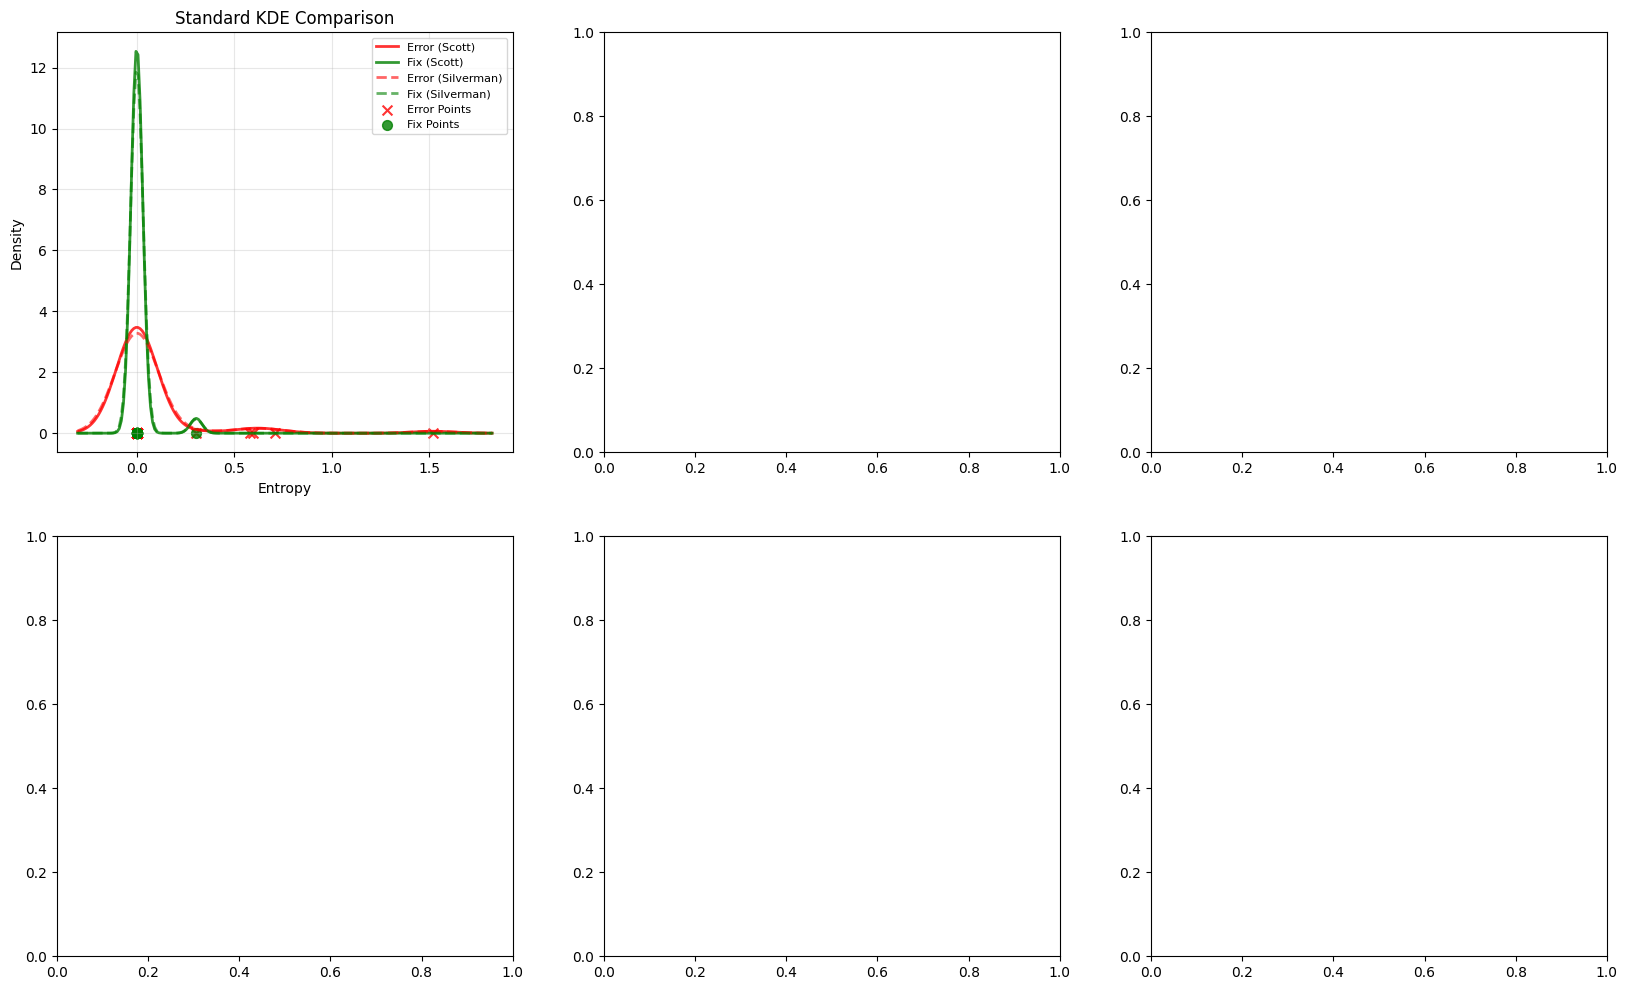

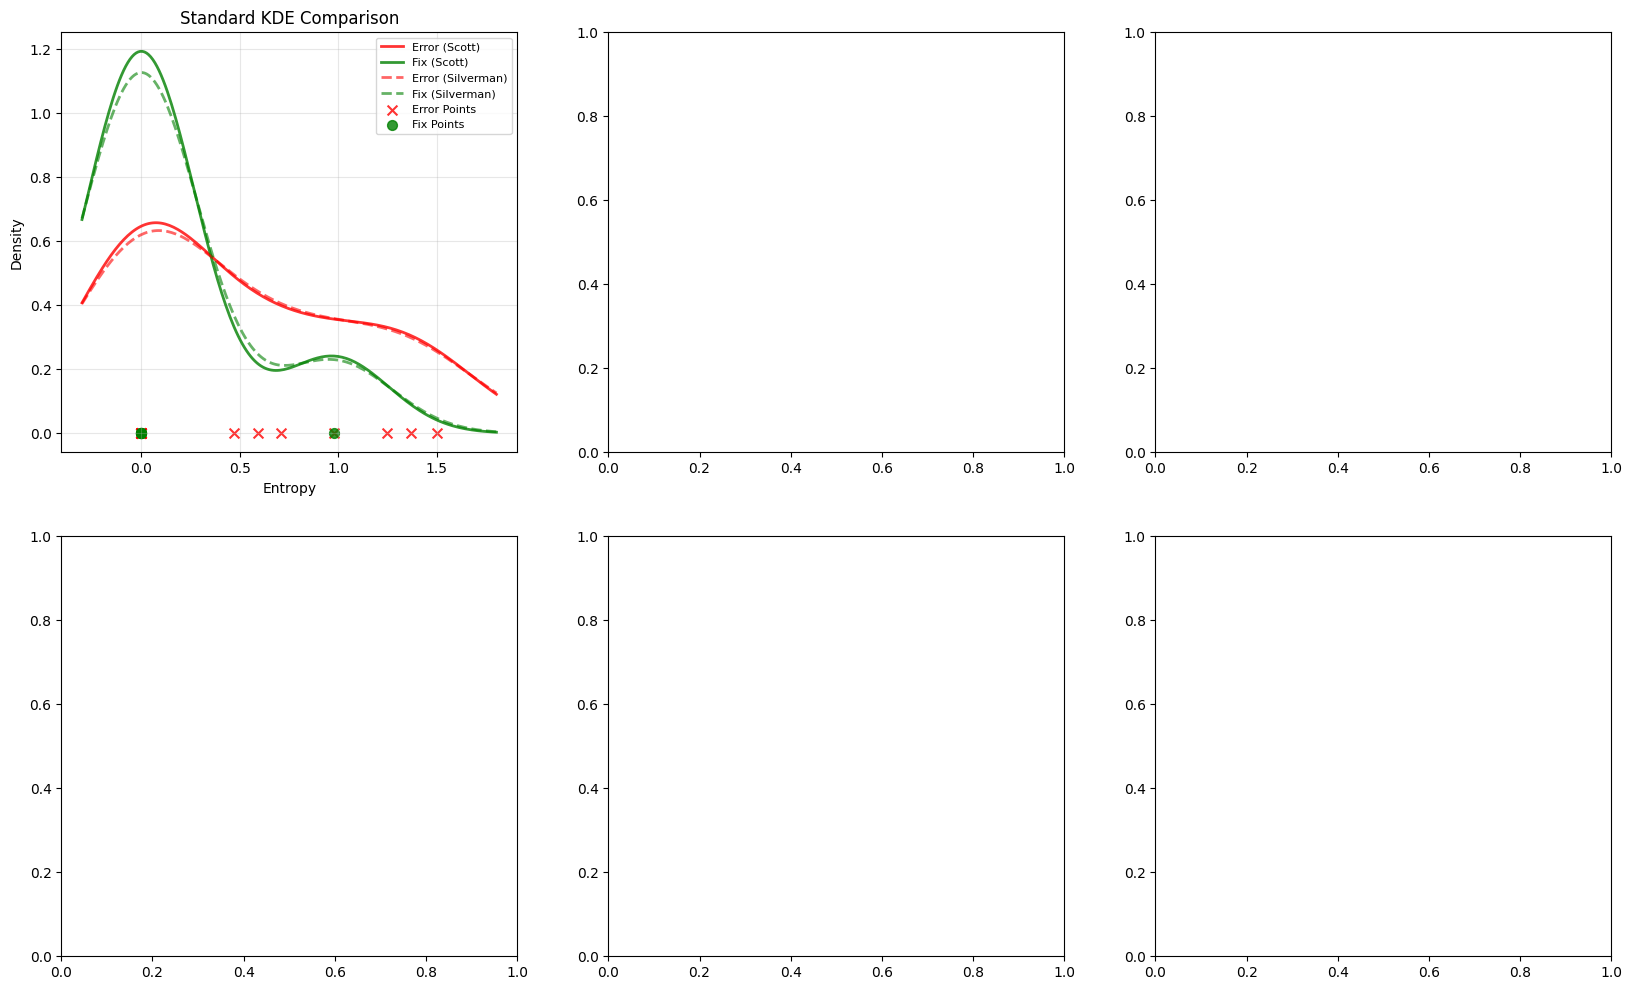

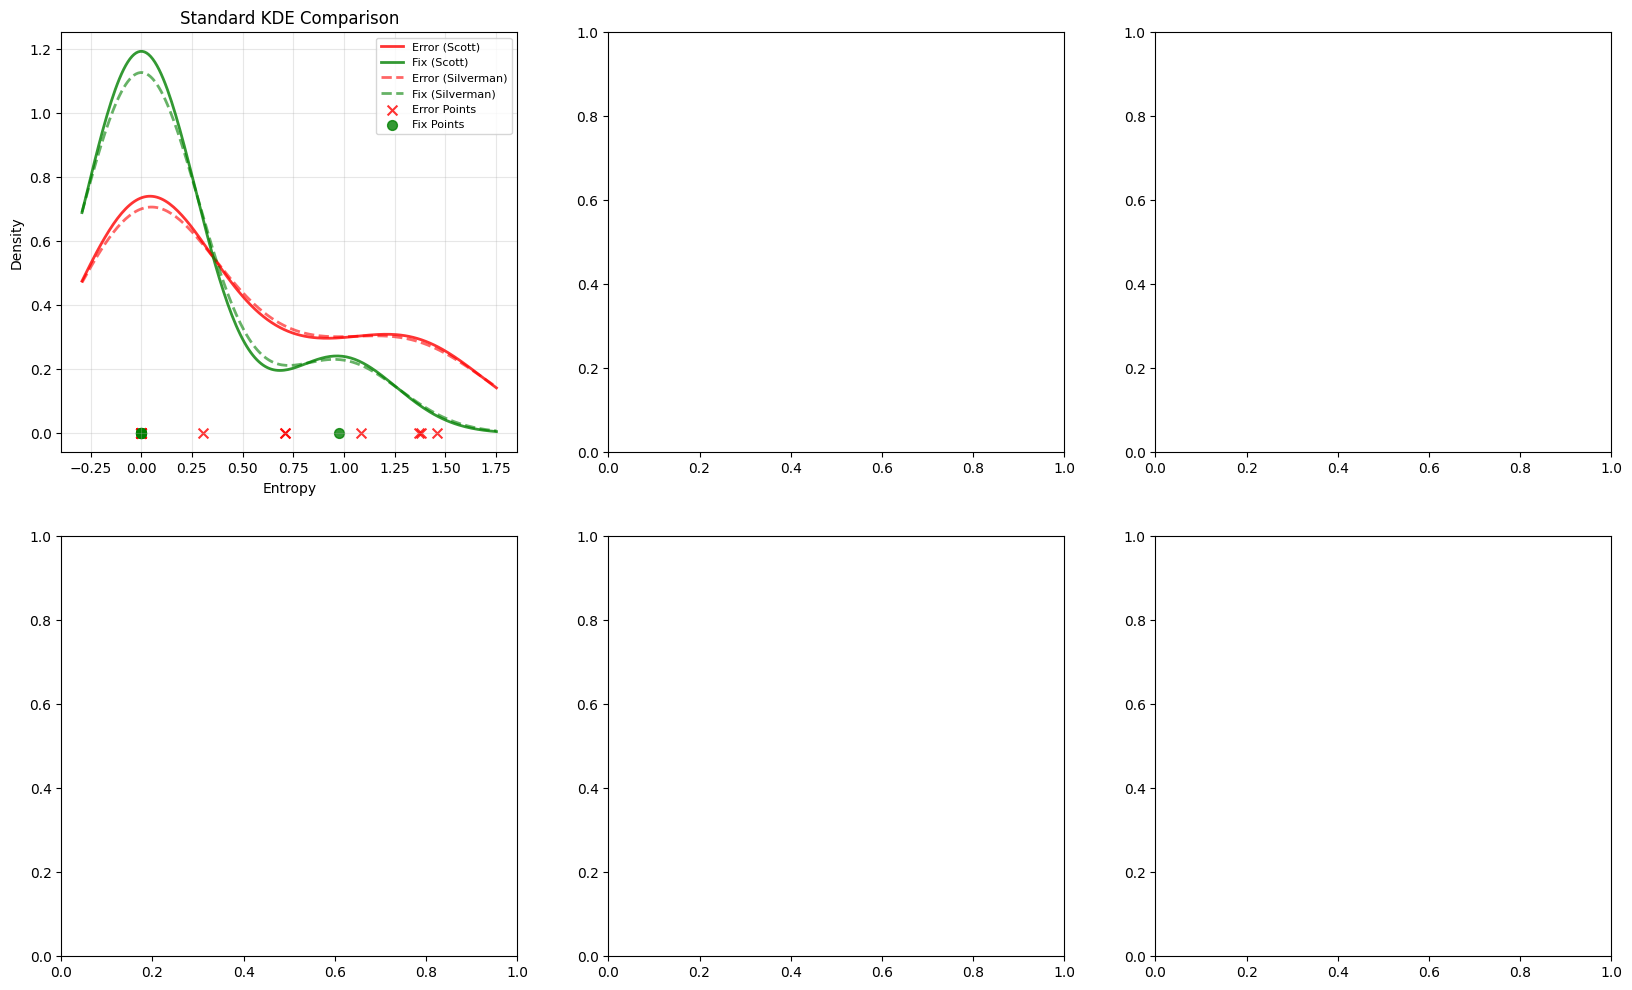

In [1]:
# -*- coding: utf-8 -*-
"""
Fix Region vs Error Region Comparison Analysis
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from scipy.stats import gaussian_kde
import gc
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

# ✅ 配置路径参数
start_index = 901
end_index = 950
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"

# 输入文件路径
LOGITS_JSONL_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek-math-7b-gsm-{range_tag}.jsonl"
ERROR_FIX_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-math-7b-{range_tag}_error_fix_index.json"

# ✅ 检查JSONL文件是否存在
if not os.path.exists(LOGITS_JSONL_PATH):
    print(f"⚠️ JSONL file not found: {LOGITS_JSONL_PATH}")
    print("Converting JSON to JSONL first...")

    # 快速转换JSON到JSONL
    json_path = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek-math-7b-gsm-{range_tag}.json"

    def convert_json_to_jsonl_chunked(json_path, jsonl_path, chunk_size=10):
        """分块转换JSON到JSONL以节省内存"""
        print(f"🔄 Converting {json_path} to JSONL...")

        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        total_items = len(data)
        print(f"📊 Total items: {total_items}")

        with open(jsonl_path, 'w', encoding='utf-8') as f:
            for i, (qid, sample) in enumerate(data.items()):
                line_data = {"qid": qid, "data": sample}
                f.write(json.dumps(line_data, ensure_ascii=False) + '\n')

                if (i + 1) % chunk_size == 0:
                    print(f"📈 Converted {i + 1}/{total_items}")
                    f.flush()  # 强制写入磁盘

        # 清理内存
        del data
        gc.collect()
        print(f"✅ Conversion complete: {jsonl_path}")

    convert_json_to_jsonl_chunked(json_path, LOGITS_JSONL_PATH)

# ✅ 加载错误修复索引数据
print("📂 Loading error-fix index data...")
if os.path.exists(ERROR_FIX_INDEX_PATH):
    with open(ERROR_FIX_INDEX_PATH, "r") as f:
        error_fix_data = json.load(f)
    print(f"✅ Loaded error-fix data: {len(error_fix_data)} questions")
else:
    print(f"⚠️ Error-fix index file not found: {ERROR_FIX_INDEX_PATH}")
    print("Please run the error analysis script first!")
    exit()

# ✅ 输出路径
OUTPUT_DIR = f"{BASE_PATH}/output/kde_fix_error_region_comparison"
SIMPLE_KDE_DIR = f"{BASE_PATH}/output/kde_fix_error_simple_kde"
COMPREHENSIVE_KDE_DIR = f"{BASE_PATH}/output/kde_fix_error_comprehensive_kde"
COVARIANCE_DIR = f"{BASE_PATH}/output/kde_fix_error_covariance_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(SIMPLE_KDE_DIR, exist_ok=True)
os.makedirs(COMPREHENSIVE_KDE_DIR, exist_ok=True)
os.makedirs(COVARIANCE_DIR, exist_ok=True)

# ✅ 流式加载单个样本的logits数据
def load_sample_logits(qid, sampling_ids):
    """
    从JSONL文件中流式加载指定样本的logits数据
    """
    sample_data = {}

    with open(LOGITS_JSONL_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            line_data = json.loads(line.strip())
            if line_data["qid"] == qid:
                data = line_data["data"]
                # 只提取需要的sampling数据
                for sid in sampling_ids:
                    if sid in data:
                        sample_data[sid] = data[sid]
                break

    return sample_data

# ✅ 提取区间熵值的函数
def extract_region_entropy(token_probs, begin_idx, end_idx):
    """
    提取指定区间的熵值
    """
    if begin_idx < 0 or end_idx < 0 or begin_idx >= len(token_probs) or end_idx >= len(token_probs):
        return []

    entropy_values = []
    for i in range(begin_idx, min(end_idx + 1, len(token_probs))):
        entropy_values.append(token_probs[i]["topk_info"]["entropy"])

    return entropy_values

# ✅ 提取区间tokens的函数
def extract_region_tokens(token_probs, begin_idx, end_idx):
    """
    提取指定区间的tokens
    """
    if begin_idx < 0 or end_idx < 0 or begin_idx >= len(token_probs) or end_idx >= len(token_probs):
        return []

    tokens = []
    for i in range(begin_idx, min(end_idx + 1, len(token_probs))):
        tokens.append(token_probs[i]["token"])

    return tokens

# ✅ 绘制Fix Region vs Error Region对比分析
def plot_fix_error_region_comparison(qid, neg_sid, pos_sid, analysis_data, save_dir):
    """
    专门对比Fix Region和Error Region的详细分析
    """
    try:
        # 流式加载所需的样本数据
        sample_logits = load_sample_logits(qid, [neg_sid, pos_sid])

        if neg_sid not in sample_logits or pos_sid not in sample_logits:
            print(f"⚠️ Missing logits: {qid} | {neg_sid} / {pos_sid}")
            return

        neg_probs = sample_logits[neg_sid]["token_probs"]
        pos_probs = sample_logits[pos_sid]["token_probs"]

        # 获取区间位置
        error_begin = analysis_data.get("error_token_begin_index", -1)
        error_end = analysis_data.get("error_token_end_index", -1)
        fix_begin = analysis_data.get("fix_token_begin_index", -1)
        fix_end = analysis_data.get("fix_token_end_index", -1)

        # 提取区间熵值和tokens
        error_entropy = extract_region_entropy(neg_probs, error_begin, error_end)
        fix_entropy = extract_region_entropy(pos_probs, fix_begin, fix_end)
        error_tokens = extract_region_tokens(neg_probs, error_begin, error_end)
        fix_tokens = extract_region_tokens(pos_probs, fix_begin, fix_end)

        if not error_entropy or not fix_entropy:
            print(f"⚠️ Empty regions for {qid}")
            return

        # ✅ 创建对比图 (2x2 layout)
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # 子图1: Error Region详细分析
        error_indices = np.arange(error_begin, error_begin + len(error_entropy))
        axs[0, 0].plot(error_indices, error_entropy, 'ro-', linewidth=2, markersize=8, label="Error Region Entropy")
        axs[0, 0].set_title(f"Error Region Analysis ({neg_sid})\nTokens: {error_begin}-{error_end}")
        axs[0, 0].set_xlabel("Token Index")
        axs[0, 0].set_ylabel("Entropy")
        axs[0, 0].grid(True, alpha=0.3)
        axs[0, 0].legend()

        # 添加token标注
        for i, (idx, token) in enumerate(zip(error_indices, error_tokens)):
            if i % max(1, len(error_tokens) // 8) == 0:  # 限制标注数量
                axs[0, 0].annotate(f"{token[:8]}", (idx, error_entropy[i]),
                                 textcoords="offset points", xytext=(0,15),
                                 ha='center', fontsize=8, rotation=45)

        # 子图2: Fix Region详细分析
        fix_indices = np.arange(fix_begin, fix_begin + len(fix_entropy))
        axs[0, 1].plot(fix_indices, fix_entropy, 'go-', linewidth=2, markersize=8, label="Fix Region Entropy")
        axs[0, 1].set_title(f"Fix Region Analysis ({pos_sid})\nTokens: {fix_begin}-{fix_end}")
        axs[0, 1].set_xlabel("Token Index")
        axs[0, 1].set_ylabel("Entropy")
        axs[0, 1].grid(True, alpha=0.3)
        axs[0, 1].legend()

        # 添加token标注
        for i, (idx, token) in enumerate(zip(fix_indices, fix_tokens)):
            if i % max(1, len(fix_tokens) // 8) == 0:  # 限制标注数量
                axs[0, 1].annotate(f"{token[:8]}", (idx, fix_entropy[i]),
                                 textcoords="offset points", xytext=(0,15),
                                 ha='center', fontsize=8, rotation=45)

        # 子图3: 直接对比 (对齐长度)
        max_len = max(len(error_entropy), len(fix_entropy))
        normalized_pos = np.arange(max_len)

        # 填充较短的序列
        error_aligned = error_entropy + [np.nan] * (max_len - len(error_entropy))
        fix_aligned = fix_entropy + [np.nan] * (max_len - len(fix_entropy))

        axs[1, 0].plot(normalized_pos[:len(error_entropy)], error_entropy, 'ro-',
                      linewidth=2, markersize=6, label="Error Region", alpha=0.8)
        axs[1, 0].plot(normalized_pos[:len(fix_entropy)], fix_entropy, 'go-',
                      linewidth=2, markersize=6, label="Fix Region", alpha=0.8)

        axs[1, 0].set_title("Direct Region Comparison")
        axs[1, 0].set_xlabel("Relative Position in Region")
        axs[1, 0].set_ylabel("Entropy")
        axs[1, 0].legend()
        axs[1, 0].grid(True, alpha=0.3)

        # 子图4: 统计对比
        error_stats = {
            'mean': np.mean(error_entropy),
            'std': np.std(error_entropy),
            'min': np.min(error_entropy),
            'max': np.max(error_entropy)
        }
        fix_stats = {
            'mean': np.mean(fix_entropy),
            'std': np.std(fix_entropy),
            'min': np.min(fix_entropy),
            'max': np.max(fix_entropy)
        }

        categories = ['Mean', 'Std', 'Min', 'Max']
        error_values = [error_stats['mean'], error_stats['std'], error_stats['min'], error_stats['max']]
        fix_values = [fix_stats['mean'], fix_stats['std'], fix_stats['min'], fix_stats['max']]

        x = np.arange(len(categories))
        width = 0.35

        axs[1, 1].bar(x - width/2, error_values, width, label='Error Region', color='red', alpha=0.7)
        axs[1, 1].bar(x + width/2, fix_values, width, label='Fix Region', color='green', alpha=0.7)

        axs[1, 1].set_title("Statistical Comparison")
        axs[1, 1].set_xlabel("Statistics")
        axs[1, 1].set_ylabel("Entropy Value")
        axs[1, 1].set_xticks(x)
        axs[1, 1].set_xticklabels(categories)
        axs[1, 1].legend()
        axs[1, 1].grid(True, alpha=0.3)

        # 添加数值标签
        for i, (err_val, fix_val) in enumerate(zip(error_values, fix_values)):
            axs[1, 1].text(i - width/2, err_val + 0.01, f'{err_val:.3f}',
                          ha='center', va='bottom', fontsize=8)
            axs[1, 1].text(i + width/2, fix_val + 0.01, f'{fix_val:.3f}',
                          ha='center', va='bottom', fontsize=8)

        # 设置整体标题
        fig.suptitle(f"Fix vs Error Region Analysis: {qid} | {neg_sid} vs {pos_sid}",
                    fontsize=16, y=0.98)
        plt.tight_layout()

        # 保存图片
        fname = f"{qid}_{neg_sid}_vs_{pos_sid}_fix_error_comparison.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches='tight')
        plt.close()

        # 清理内存
        del sample_logits, neg_probs, pos_probs
        gc.collect()

        print(f"✅ Saved comparison: {fname}")

        # 返回统计信息用于后续分析
        return {
            'qid': qid,
            'error_stats': error_stats,
            'fix_stats': fix_stats,
            'error_length': len(error_entropy),
            'fix_length': len(fix_entropy)
        }

    except Exception as e:
        print(f"❌ Comparison failed {qid} | {neg_sid} vs {pos_sid}: {e}")
        return None

# ✅ 自适应KDE函数
def adaptive_kde(x, y, grid, pilot_bw='scott', alpha=0.5):
    """
    自适应KDE：基于熵值加权的密度估计
    x: 每个 step 的索引（0,1,2,...）
    y: 对应 step 的熵值列表
    grid: 平滑后要评估的横坐标点集合
    pilot_bw: 初始带宽规则 ('scott' 或 'silverman' 或数值)
    alpha: Abramson 校正指数，0.5 表示开方校正
    """
    if len(x) < 2 or len(y) < 2:
        return np.zeros_like(grid)

    # 1) pilot KDE：用带权重 y 的 x 值估计初始密度 f_pilot(x)
    kde_pilot = gaussian_kde(x, bw_method=pilot_bw, weights=y)
    f_pilot = kde_pilot(x)
    # 取几何平均 g
    g = np.exp(np.mean(np.log(f_pilot + 1e-12)))

    # 2) 计算每个点的本地带宽 h_i
    h0 = kde_pilot.factor
    h_i = h0 * (g / (f_pilot + 1e-12))**alpha

    # 3) 在 grid 上累加各高斯核
    pdf = np.zeros_like(grid)
    for xi, yi, hi in zip(x, y, h_i):
        pdf += yi * np.exp(-0.5*((grid - xi)/hi)**2) / (hi * np.sqrt(2*np.pi))

    # 归一化
    if pdf.sum() > 0:
        pdf /= pdf.sum() * (grid[1] - grid[0])
    return pdf

# ✅ 全面的KDE分析
def plot_comprehensive_kde_analysis(qid, neg_sid, pos_sid, analysis_data, save_dir):
    """
    使用多种KDE方法对比Error Region和Fix Region的熵分布
    """
    try:
        # 流式加载所需的样本数据
        sample_logits = load_sample_logits(qid, [neg_sid, pos_sid])

        if neg_sid not in sample_logits or pos_sid not in sample_logits:
            return

        neg_probs = sample_logits[neg_sid]["token_probs"]
        pos_probs = sample_logits[pos_sid]["token_probs"]

        # 获取区间位置
        error_begin = analysis_data.get("error_token_begin_index", -1)
        error_end = analysis_data.get("error_token_end_index", -1)
        fix_begin = analysis_data.get("fix_token_begin_index", -1)
        fix_end = analysis_data.get("fix_token_end_index", -1)

        # 提取区间熵值
        error_entropy = extract_region_entropy(neg_probs, error_begin, error_end)
        fix_entropy = extract_region_entropy(pos_probs, fix_begin, fix_end)

        if not error_entropy or not fix_entropy:
            return

        # ✅ 创建综合KDE分析图 (2x3 layout)
        fig, axs = plt.subplots(2, 3, figsize=(20, 12))

        # === 第一行：基础KDE分析 ===

        # 子图1: 标准KDE密度对比
        if len(error_entropy) > 1 and len(fix_entropy) > 1:
            kde_error_scott = gaussian_kde(error_entropy, bw_method='scott')
            kde_error_silverman = gaussian_kde(error_entropy, bw_method='silverman')
            kde_fix_scott = gaussian_kde(fix_entropy, bw_method='scott')
            kde_fix_silverman = gaussian_kde(fix_entropy, bw_method='silverman')

            # 创建评估网格
            all_entropy = error_entropy + fix_entropy
            x_min, x_max = min(all_entropy), max(all_entropy)
            x_range = x_max - x_min
            xs = np.linspace(x_min - 0.2*x_range, x_max + 0.2*x_range, 200)

            # Scott方法
            axs[0, 0].plot(xs, kde_error_scott(xs), color='red', linewidth=2,
                          linestyle='-', label='Error (Scott)', alpha=0.8)
            axs[0, 0].plot(xs, kde_fix_scott(xs), color='green', linewidth=2,
                          linestyle='-', label='Fix (Scott)', alpha=0.8)

            # Silverman方法
            axs[0, 0].plot(xs, kde_error_silverman(xs), color='red', linewidth=2,
                          linestyle='--', label='Error (Silverman)', alpha=0.6)
            axs[0, 0].plot(xs, kde_fix_silverman(xs), color='green', linewidth=2,
                          linestyle='--', label='Fix (Silverman)', alpha=0.6)

            # 添加原始数据点
            axs[0, 0].scatter(error_entropy, [0]*len(error_entropy), color='red',
                             marker='x', s=50, alpha=0.8, label='Error Points')
            axs[0, 0].scatter(fix_entropy, [0]*len(fix_entropy), color='green',
                             marker='o', s=50, alpha=0.8, label='Fix Points')

            axs[0, 0].set_title("Standard KDE Comparison")
            axs[0, 0].set_xlabel("Entropy")
            axs[0, 0].set_ylabel("Density")
            axs[0, 0].legend(fontsize=8)
            axs[0, 0].grid(True, alpha=0.3)

        # 子图2: 自适应KDE分析
        error_indices = np.arange(len(error_entropy))
        fix_indices = np.arange(len(fix_entropy))

        if len(error_entropy) > 1 and len(fix_entropy) > 1:
            # 为自适应KDE创建网格
            max_len = max(len(error_entropy), len(fix_entropy))
            grid = np.linspace(0, max_len-1, 100)

            # 自适应KDE
            adaptive_error = adaptive_kde(error_indices, error_entropy, grid)
            adaptive_fix = adaptive_kde(fix_indices, fix_entropy, grid)

            axs[0, 1].plot(grid, adaptive_error, color='red', linewidth=3,
                          label='Error Region (Adaptive KDE)', alpha=0.8)
            axs[0, 1].plot(grid, adaptive_fix, color='green', linewidth=3,
                          label='Fix Region (Adaptive KDE)', alpha=0.8)

            # 添加原始序列
            axs[0, 1].plot(error_indices, np.array(error_entropy)/max(error_entropy),
                          'ro-', alpha=0.5, markersize=4, label='Error Original (Normalized)')
            axs[0, 1].plot(fix_indices, np.array(fix_entropy)/max(fix_entropy),
                          'go-', alpha=0.5, markersize=4, label='Fix Original (Normalized)')

            axs[0, 1].set_title("Adaptive KDE Analysis")
            axs[0, 1].set_xlabel("Position Index")
            axs[0, 1].set_ylabel("Adaptive Density")
            axs[0, 1].legend(fontsize=8)
            axs[0, 1].grid(True, alpha=0.3)

        # 子图3: KDE带宽对比分析
        if len(error_entropy) > 1 and len(fix_entropy) > 1:
            bandwidths = [0.1, 0.2, 0.5, 1.0]
            colors_bw = ['darkred', 'red', 'lightcoral', 'pink']

            for i, bw in enumerate(bandwidths):
                kde_error_bw = gaussian_kde(error_entropy, bw_method=bw)
                axs[0, 2].plot(xs, kde_error_bw(xs), color=colors_bw[i],
                              linewidth=2, label=f'Error BW={bw}', alpha=0.7)

            # 添加数据点
            axs[0, 2].scatter(error_entropy, [0]*len(error_entropy), color='red',
                             marker='x', s=40, alpha=0.8)

            axs[0, 2].set_title("Bandwidth Sensitivity (Error Region)")
            axs[0, 2].set_xlabel("Entropy")
            axs[0, 2].set_ylabel("Density")
            axs[0, 2].legend(fontsize=8)
            axs[0, 2].grid(True, alpha=0.3)

        # === 第二行：高级KDE分析 ===

        # 子图4: KDE差异分析
        if len(error_entropy) > 1 and len(fix_entropy) > 1:
            kde_error = gaussian_kde(error_entropy, bw_method='scott')
            kde_fix = gaussian_kde(fix_entropy, bw_method='scott')

            error_density = kde_error(xs)
            fix_density = kde_fix(xs)
            density_diff = error_density - fix_density

            axs[1, 0].plot(xs, error_density, color='red', linewidth=2,
                          label='Error KDE', alpha=0.8)
            axs[1, 0].plot(xs, fix_density, color='green', linewidth=2,
                          label='Fix KDE', alpha=0.8)
            axs[1, 0].fill_between(xs, 0, density_diff, where=(density_diff > 0),
                                  color='red', alpha=0.3, label='Error > Fix')
            axs[1, 0].fill_between(xs, 0, density_diff, where=(density_diff < 0),
                                  color='green', alpha=0.3, label='Fix > Error')
            axs[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

            axs[1, 0].set_title("KDE Difference Analysis")
            axs[1, 0].set_xlabel("Entropy")
            axs[1, 0].set_ylabel("Density / Difference")
            axs[1, 0].legend(fontsize=8)
            axs[1, 0].grid(True, alpha=0.3)

        # 子图5: 累积分布函数对比
        if len(error_entropy) > 1 and len(fix_entropy) > 1:
            # 计算经验CDF
            error_sorted = np.sort(error_entropy)
            fix_sorted = np.sort(fix_entropy)

            error_cdf = np.arange(1, len(error_sorted) + 1) / len(error_sorted)
            fix_cdf = np.arange(1, len(fix_sorted) + 1) / len(fix_sorted)

            axs[1, 1].plot(error_sorted, error_cdf, color='red', linewidth=3,
                          label='Error Region CDF', marker='o', markersize=4)
            axs[1, 1].plot(fix_sorted, fix_cdf, color='green', linewidth=3,
                          label='Fix Region CDF', marker='s', markersize=4)

            # 添加分位数线
            for q in [0.25, 0.5, 0.75]:
                error_q = np.quantile(error_entropy, q)
                fix_q = np.quantile(fix_entropy, q)
                axs[1, 1].axhline(y=q, color='gray', linestyle='--', alpha=0.5)
                axs[1, 1].axvline(x=error_q, color='red', linestyle=':', alpha=0.5)
                axs[1, 1].axvline(x=fix_q, color='green', linestyle=':', alpha=0.5)

            axs[1, 1].set_title("Cumulative Distribution Comparison")
            axs[1, 1].set_xlabel("Entropy")
            axs[1, 1].set_ylabel("Cumulative Probability")
            axs[1, 1].legend(fontsize=8)
            axs[1, 1].grid(True, alpha=0.3)

        # 子图6: 统计摘要和KL散度
        axs[1, 2].axis('tight')
        axs[1, 2].axis('off')

        # 计算统计量
        error_stats = {
            'Mean': np.mean(error_entropy),
            'Std': np.std(error_entropy),
            'Median': np.median(error_entropy),
            'Q25': np.quantile(error_entropy, 0.25),
            'Q75': np.quantile(error_entropy, 0.75),
            'Min': np.min(error_entropy),
            'Max': np.max(error_entropy),
            'Length': len(error_entropy)
        }

        fix_stats = {
            'Mean': np.mean(fix_entropy),
            'Std': np.std(fix_entropy),
            'Median': np.median(fix_entropy),
            'Q25': np.quantile(fix_entropy, 0.25),
            'Q75': np.quantile(fix_entropy, 0.75),
            'Min': np.min(fix_entropy),
            'Max': np.max(fix_entropy),
            'Length': len(fix_entropy)
        }

        # 创建统计表格
        table_data = []
        for key in error_stats.keys():
            if key == 'Length':
                table_data.append([key, str(error_stats[key]), str(fix_stats[key]), '-'])
            else:
                diff = fix_stats[key] - error_stats[key]
                table_data.append([key, f"{error_stats[key]:.4f}",
                                 f"{fix_stats[key]:.4f}", f"{diff:+.4f}"])

        table = axs[1, 2].table(cellText=table_data,
                               colLabels=['Statistic', 'Error Region', 'Fix Region', 'Difference'],
                               cellLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.8)
        axs[1, 2].set_title('Statistical Summary')

        # 设置整体标题
        fig.suptitle(f"Comprehensive KDE Analysis: {qid} | {neg_sid} vs {pos_sid}",
                    fontsize=16, y=0.98)
        plt.tight_layout()

        # 保存图片
        fname = f"{qid}_{neg_sid}_vs_{pos_sid}_comprehensive_kde.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches='tight')
        plt.close()

        # 清理内存
        del sample_logits, neg_probs, pos_probs
        gc.collect()

        print(f"✅ Saved comprehensive KDE analysis: {fname}")

        return {
            'qid': qid,
            'error_stats': error_stats,
            'fix_stats': fix_stats
        }

    except Exception as e:
        print(f"❌ Comprehensive KDE analysis failed {qid}: {e}")
        return None

# ✅ 协方差和相关性分析
def plot_covariance_analysis(qid, neg_sid, pos_sid, analysis_data, save_dir):
    """
    协方差和相关性分析：Error Region vs Fix Region
    """
    try:
        # 流式加载所需的样本数据
        sample_logits = load_sample_logits(qid, [neg_sid, pos_sid])

        if neg_sid not in sample_logits or pos_sid not in sample_logits:
            return None

        neg_probs = sample_logits[neg_sid]["token_probs"]
        pos_probs = sample_logits[pos_sid]["token_probs"]

        # 获取区间位置
        error_begin = analysis_data.get("error_token_begin_index", -1)
        error_end = analysis_data.get("error_token_end_index", -1)
        fix_begin = analysis_data.get("fix_token_begin_index", -1)
        fix_end = analysis_data.get("fix_token_end_index", -1)

        # 提取区间熵值
        error_entropy = extract_region_entropy(neg_probs, error_begin, error_end)
        fix_entropy = extract_region_entropy(pos_probs, fix_begin, fix_end)

        if not error_entropy or not fix_entropy or len(error_entropy) < 2 or len(fix_entropy) < 2:
            return None

        # ✅ 协方差分析准备
        # 1. 对齐长度 - 用于直接比较
        min_len = min(len(error_entropy), len(fix_entropy))
        max_len = max(len(error_entropy), len(fix_entropy))

        # 截取相同长度
        error_aligned = error_entropy[:min_len]
        fix_aligned = fix_entropy[:min_len]

        # 插值到相同长度（线性插值）
        from scipy import interpolate
        error_indices = np.linspace(0, 1, len(error_entropy))
        fix_indices = np.linspace(0, 1, len(fix_entropy))
        common_indices = np.linspace(0, 1, max_len)

        f_error = interpolate.interp1d(error_indices, error_entropy, kind='linear')
        f_fix = interpolate.interp1d(fix_indices, fix_entropy, kind='linear')

        error_interp = f_error(common_indices)
        fix_interp = f_fix(common_indices)

        # ✅ 协方差计算
        # 1. 直接协方差（截取版本）
        cov_direct = np.cov(error_aligned, fix_aligned)[0, 1]
        corr_direct = np.corrcoef(error_aligned, fix_aligned)[0, 1]

        # 2. 插值协方差（插值版本）
        cov_interp = np.cov(error_interp, fix_interp)[0, 1]
        corr_interp = np.corrcoef(error_interp, fix_interp)[0, 1]

        # 3. 时间序列协方差（滞后分析）
        max_lag = min(10, min_len // 2)
        cross_corr = []
        lags = range(-max_lag, max_lag + 1)

        for lag in lags:
            if lag >= 0:
                x = error_aligned[:-lag] if lag > 0 else error_aligned
                y = fix_aligned[lag:] if lag > 0 else fix_aligned
            else:
                x = error_aligned[-lag:]
                y = fix_aligned[:lag] if lag < 0 else fix_aligned

            if len(x) > 1 and len(y) > 1 and len(x) == len(y):
                cross_corr.append(np.corrcoef(x, y)[0, 1])
            else:
                cross_corr.append(0)

        # 4. 局部协方差（滑动窗口）
        window_size = min(5, min_len // 3)
        local_corr = []
        local_cov = []
        window_centers = []

        for i in range(window_size, min_len - window_size):
            window_error = error_aligned[i-window_size:i+window_size]
            window_fix = fix_aligned[i-window_size:i+window_size]

            if len(window_error) > 1:
                local_cov.append(np.cov(window_error, window_fix)[0, 1])
                local_corr.append(np.corrcoef(window_error, window_fix)[0, 1])
                window_centers.append(i)

        # ✅ 创建协方差分析图 (2x3 layout)
        fig, axs = plt.subplots(2, 3, figsize=(20, 12))

        # 子图1: 对齐数据散点图 + 协方差椭圆
        axs[0, 0].scatter(error_aligned, fix_aligned, alpha=0.7, s=50, c=range(len(error_aligned)), cmap='viridis')
        axs[0, 0].set_xlabel('Error Region Entropy')
        axs[0, 0].set_ylabel('Fix Region Entropy')
        axs[0, 0].set_title(f'Aligned Data Correlation\nCorr: {corr_direct:.4f}, Cov: {cov_direct:.4f}')

        # 添加拟合线
        if not np.isnan(corr_direct):
            z = np.polyfit(error_aligned, fix_aligned, 1)
            p = np.poly1d(z)
            axs[0, 0].plot(error_aligned, p(error_aligned), "r--", alpha=0.8, linewidth=2)

        # 添加协方差椭圆
        def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
            if len(x) != len(y):
                return
            cov = np.cov(x, y)
            pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
            ell_radius_x = np.sqrt(1 + pearson)
            ell_radius_y = np.sqrt(1 - pearson)
            from matplotlib.patches import Ellipse
            ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                             facecolor=facecolor, **kwargs)
            scale_x = np.sqrt(cov[0, 0]) * n_std
            mean_x = np.mean(x)
            scale_y = np.sqrt(cov[1, 1]) * n_std
            mean_y = np.mean(y)
            transf = transforms.Affine2D() \
                .rotate_deg(45) \
                .scale(scale_x, scale_y) \
                .translate(mean_x, mean_y)
            ellipse.set_transform(transf + ax.transData)
            return ax.add_patch(ellipse)

        try:
            from matplotlib import transforms
            confidence_ellipse(error_aligned, fix_aligned, axs[0, 0],
                             facecolor='red', alpha=0.2, edgecolor='red')
        except:
            pass

        axs[0, 0].grid(True, alpha=0.3)

        # 子图2: 插值数据对比
        axs[0, 1].plot(common_indices, error_interp, 'r-', linewidth=2, label='Error Region', alpha=0.8)
        axs[0, 1].plot(common_indices, fix_interp, 'g-', linewidth=2, label='Fix Region', alpha=0.8)
        axs[0, 1].fill_between(common_indices, error_interp, fix_interp,
                              alpha=0.3, color='blue', label=f'Difference Area')
        axs[0, 1].set_xlabel('Normalized Position')
        axs[0, 1].set_ylabel('Entropy')
        axs[0, 1].set_title(f'Interpolated Comparison\nCorr: {corr_interp:.4f}, Cov: {cov_interp:.4f}')
        axs[0, 1].legend()
        axs[0, 1].grid(True, alpha=0.3)

        # 子图3: 交叉相关分析
        axs[0, 2].plot(lags, cross_corr, 'bo-', linewidth=2, markersize=6)
        axs[0, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axs[0, 2].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero Lag')
        max_corr_idx = np.argmax(np.abs(cross_corr))
        max_lag = lags[max_corr_idx]
        max_corr_val = cross_corr[max_corr_idx]
        axs[0, 2].axvline(x=max_lag, color='green', linestyle='--', alpha=0.7,
                         label=f'Max Corr Lag: {max_lag}')
        axs[0, 2].set_xlabel('Lag')
        axs[0, 2].set_ylabel('Cross Correlation')
        axs[0, 2].set_title(f'Cross Correlation Analysis\nMax: {max_corr_val:.4f} at lag {max_lag}')
        axs[0, 2].legend()
        axs[0, 2].grid(True, alpha=0.3)

        # 子图4: 局部协方差分析
        if local_corr:
            axs[1, 0].plot(window_centers, local_corr, 'ro-', linewidth=2, markersize=4,
                          label='Local Correlation', alpha=0.8)
            axs[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axs[1, 0].axhline(y=corr_direct, color='blue', linestyle='--', alpha=0.7,
                             label=f'Global Corr: {corr_direct:.4f}')
            axs[1, 0].set_xlabel('Position')
            axs[1, 0].set_ylabel('Local Correlation')
            axs[1, 0].set_title('Local Correlation (Sliding Window)')
            axs[1, 0].legend()
            axs[1, 0].grid(True, alpha=0.3)

        # 子图5: 协方差矩阵热图
        # 构建多变量数据进行协方差分析
        # 包括：均值、方差、偏度、峰度等统计量
        from scipy.stats import skew, kurtosis

        error_stats_vec = [
            np.mean(error_entropy),
            np.std(error_entropy),
            skew(error_entropy),
            kurtosis(error_entropy),
            np.min(error_entropy),
            np.max(error_entropy)
        ]

        fix_stats_vec = [
            np.mean(fix_entropy),
            np.std(fix_entropy),
            skew(fix_entropy),
            kurtosis(fix_entropy),
            np.min(fix_entropy),
            np.max(fix_entropy)
        ]

        # 创建统计量协方差矩阵
        stats_data = np.array([error_stats_vec, fix_stats_vec])
        stats_cov = np.cov(stats_data)

        im = axs[1, 1].imshow(stats_cov, cmap='RdBu_r', aspect='auto')
        axs[1, 1].set_xticks([0, 1])
        axs[1, 1].set_yticks([0, 1])
        axs[1, 1].set_xticklabels(['Error Stats', 'Fix Stats'])
        axs[1, 1].set_yticklabels(['Error Stats', 'Fix Stats'])
        axs[1, 1].set_title('Statistics Covariance Matrix')

        # 添加数值标注
        for i in range(2):
            for j in range(2):
                text = axs[1, 1].text(j, i, f'{stats_cov[i, j]:.4f}',
                                     ha="center", va="center", color="white", fontweight='bold')

        plt.colorbar(im, ax=axs[1, 1])

        # 子图6: 协方差分解分析
        axs[1, 2].axis('tight')
        axs[1, 2].axis('off')

        # 计算更多协方差相关指标
        error_var = np.var(error_entropy)
        fix_var = np.var(fix_entropy)
        covar = cov_direct

        # 协方差分解
        covar_coeff = covar / (np.sqrt(error_var) * np.sqrt(fix_var)) if error_var > 0 and fix_var > 0 else 0

        # 创建协方差摘要表
        cov_table_data = [
            ['Error Variance', f'{error_var:.6f}'],
            ['Fix Variance', f'{fix_var:.6f}'],
            ['Covariance', f'{covar:.6f}'],
            ['Correlation', f'{corr_direct:.6f}'],
            ['Covar Coefficient', f'{covar_coeff:.6f}'],
            ['Cross-Corr Max', f'{max_corr_val:.6f}'],
            ['Best Lag', f'{max_lag}'],
            ['Sample Size', f'{min_len}'],
            ['Error Length', f'{len(error_entropy)}'],
            ['Fix Length', f'{len(fix_entropy)}']
        ]

        table = axs[1, 2].table(cellText=cov_table_data,
                               colLabels=['Metric', 'Value'],
                               cellLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 2.0)
        axs[1, 2].set_title('Covariance Analysis Summary')

        # 设置整体标题
        fig.suptitle(f"Covariance Analysis: {qid} | {neg_sid} vs {pos_sid}",
                    fontsize=16, y=0.98)
        plt.tight_layout()

        # 保存图片
        fname = f"{qid}_{neg_sid}_vs_{pos_sid}_covariance_analysis.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches='tight')
        plt.close()

        # 清理内存
        del sample_logits, neg_probs, pos_probs
        gc.collect()

        print(f"✅ Saved covariance analysis: {fname}")

        return {
            'qid': qid,
            'direct_correlation': corr_direct,
            'direct_covariance': cov_direct,
            'interp_correlation': corr_interp,
            'interp_covariance': cov_interp,
            'max_cross_correlation': max_corr_val,
            'best_lag': max_lag,
            'error_variance': error_var,
            'fix_variance': fix_var,
            'sample_size': min_len
        }

    except Exception as e:
        print(f"❌ Covariance analysis failed {qid}: {e}")
        return None
def plot_simple_kde_comparison(qid, neg_sid, pos_sid, analysis_data, save_dir):
    """
    简化版KDE对比图
    """
    try:
        # 流式加载所需的样本数据
        sample_logits = load_sample_logits(qid, [neg_sid, pos_sid])

        if neg_sid not in sample_logits or pos_sid not in sample_logits:
            return

        neg_probs = sample_logits[neg_sid]["token_probs"]
        pos_probs = sample_logits[pos_sid]["token_probs"]

        # 获取区间位置
        error_begin = analysis_data.get("error_token_begin_index", -1)
        error_end = analysis_data.get("error_token_end_index", -1)
        fix_begin = analysis_data.get("fix_token_begin_index", -1)
        fix_end = analysis_data.get("fix_token_end_index", -1)

        # 提取区间熵值
        error_entropy = extract_region_entropy(neg_probs, error_begin, error_end)
        fix_entropy = extract_region_entropy(pos_probs, fix_begin, fix_end)

        if not error_entropy or not fix_entropy or len(error_entropy) < 2 or len(fix_entropy) < 2:
            return

        # 计算KDE
        kde_error = gaussian_kde(error_entropy, bw_method='silverman')
        kde_fix = gaussian_kde(fix_entropy, bw_method='silverman')

        # 创建评估网格
        all_entropy = error_entropy + fix_entropy
        x_min, x_max = min(all_entropy), max(all_entropy)
        x_range = x_max - x_min
        xs = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 200)

        # ✅ 创建简化KDE对比图
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # 子图1: KDE密度对比
        axs[0].plot(xs, kde_error(xs), color='red', linewidth=3, label='Error Region KDE', alpha=0.8)
        axs[0].plot(xs, kde_fix(xs), color='green', linewidth=3, label='Fix Region KDE', alpha=0.8)

        # 添加原始数据点
        axs[0].scatter(error_entropy, [0]*len(error_entropy), color='red',
                      marker='x', s=60, alpha=0.8, label='Error Region Points')
        axs[0].scatter(fix_entropy, [0]*len(fix_entropy), color='green',
                      marker='o', s=60, alpha=0.8, label='Fix Region Points')

        # 添加均值线
        axs[0].axvline(np.mean(error_entropy), color='red', linestyle='--',
                      alpha=0.7, label=f'Error Mean: {np.mean(error_entropy):.3f}')
        axs[0].axvline(np.mean(fix_entropy), color='green', linestyle='--',
                      alpha=0.7, label=f'Fix Mean: {np.mean(fix_entropy):.3f}')

        axs[0].set_title(f"KDE Density Comparison\n{qid}")
        axs[0].set_xlabel("Entropy")
        axs[0].set_ylabel("Density")
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)

        # 子图2: 箱线图对比
        box_data = [error_entropy, fix_entropy]
        box_labels = ['Error Region', 'Fix Region']
        colors = ['red', 'green']

        bp = axs[1].boxplot(box_data, labels=box_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        # 添加原始数据点
        for i, (data, color) in enumerate(zip(box_data, colors)):
            y = np.random.normal(i+1, 0.04, size=len(data))
            axs[1].scatter(y, data, alpha=0.6, color=color, s=30)

        axs[1].set_title("Box Plot Comparison")
        axs[1].set_ylabel("Entropy")
        axs[1].grid(True, alpha=0.3)

        plt.tight_layout()

        # 保存图片
        fname = f"{qid}_{neg_sid}_vs_{pos_sid}_simple_kde.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches='tight')
        plt.close()

        # 清理内存
        del sample_logits, neg_probs, pos_probs
        gc.collect()

        print(f"✅ Saved simple KDE comparison: {fname}")

    except Exception as e:
        print(f"❌ Simple KDE comparison failed {qid}: {e}")

# ✅ 主处理循环
print("\n🚀 Starting Fix vs Error Region comparison analysis...")

# 统计信息
total_samples = 0
processed_count = 0
error_count = 0
all_stats = []
all_cov_stats = []

# 逐个处理样本
for qid, sample_data in error_fix_data.items():
    for neg_sid, analysis in sample_data.items():
        pos_sid = analysis.get("correct_sampling_id")
        if pos_sid:
            total_samples += 1

            try:
                print(f"🔍 Processing {total_samples}: {qid} | {neg_sid} vs {pos_sid}")

                # 生成Fix vs Error Region对比图
                stats = plot_fix_error_region_comparison(
                    qid, neg_sid, pos_sid, analysis, OUTPUT_DIR
                )

                # 生成简化KDE对比图
                plot_simple_kde_comparison(
                    qid, neg_sid, pos_sid, analysis, SIMPLE_KDE_DIR
                )

                # 生成综合KDE分析图
                kde_stats = plot_comprehensive_kde_analysis(
                    qid, neg_sid, pos_sid, analysis, COMPREHENSIVE_KDE_DIR
                )

                # 🆕 生成协方差分析图
                cov_stats = plot_covariance_analysis(
                    qid, neg_sid, pos_sid, analysis, COVARIANCE_DIR
                )

                if stats:
                    all_stats.append(stats)
                if cov_stats:
                    all_cov_stats.append(cov_stats)

                processed_count += 1

                # 定期清理内存
                if total_samples % 5 == 0:
                    gc.collect()
                    print(f"📊 Processed {processed_count}/{total_samples} samples")

            except Exception as e:
                print(f"❌ Processing failed {qid} | {neg_sid} vs {pos_sid}: {e}")
                error_count += 1
                continue

# ✅ 生成协方差整体分析
if all_cov_stats:
    print("\n📊 Generating overall covariance statistics...")

    # 收集协方差统计数据
    correlations = [s['direct_correlation'] for s in all_cov_stats if not np.isnan(s['direct_correlation'])]
    covariances = [s['direct_covariance'] for s in all_cov_stats if not np.isnan(s['direct_covariance'])]
    cross_corrs = [s['max_cross_correlation'] for s in all_cov_stats if not np.isnan(s['max_cross_correlation'])]
    best_lags = [s['best_lag'] for s in all_cov_stats]

    if correlations:
        # 生成协方差整体统计图
        fig, axs = plt.subplots(2, 3, figsize=(18, 12))

        # 相关系数分布
        axs[0, 0].hist(correlations, bins=20, alpha=0.7, color='blue', edgecolor='black')
        axs[0, 0].axvline(np.mean(correlations), color='red', linestyle='--',
                         label=f'Mean: {np.mean(correlations):.4f}')
        axs[0, 0].set_title('Distribution of Correlations')
        axs[0, 0].set_xlabel('Correlation Coefficient')
        axs[0, 0].set_ylabel('Frequency')
        axs[0, 0].legend()
        axs[0, 0].grid(True, alpha=0.3)

        # 协方差分布
        axs[0, 1].hist(covariances, bins=20, alpha=0.7, color='green', edgecolor='black')
        axs[0, 1].axvline(np.mean(covariances), color='red', linestyle='--',
                         label=f'Mean: {np.mean(covariances):.6f}')
        axs[0, 1].set_title('Distribution of Covariances')
        axs[0, 1].set_xlabel('Covariance')
        axs[0, 1].set_ylabel('Frequency')
        axs[0, 1].legend()
        axs[0, 1].grid(True, alpha=0.3)

        # 交叉相关分布
        axs[0, 2].hist(cross_corrs, bins=20, alpha=0.7, color='orange', edgecolor='black')
        axs[0, 2].axvline(np.mean(cross_corrs), color='red', linestyle='--',
                         label=f'Mean: {np.mean(cross_corrs):.4f}')
        axs[0, 2].set_title('Distribution of Max Cross-Correlations')
        axs[0, 2].set_xlabel('Max Cross-Correlation')
        axs[0, 2].set_ylabel('Frequency')
        axs[0, 2].legend()
        axs[0, 2].grid(True, alpha=0.3)

        # 最佳滞后分布
        axs[1, 0].hist(best_lags, bins=range(min(best_lags)-1, max(best_lags)+2),
                      alpha=0.7, color='purple', edgecolor='black')
        axs[1, 0].axvline(np.mean(best_lags), color='red', linestyle='--',
                         label=f'Mean: {np.mean(best_lags):.2f}')
        axs[1, 0].set_title('Distribution of Best Lags')
        axs[1, 0].set_xlabel('Best Lag')
        axs[1, 0].set_ylabel('Frequency')
        axs[1, 0].legend()
        axs[1, 0].grid(True, alpha=0.3)

        # 相关性 vs 协方差散点图
        axs[1, 1].scatter(correlations, covariances, alpha=0.6, s=50)
        axs[1, 1].set_xlabel('Correlation')
        axs[1, 1].set_ylabel('Covariance')
        axs[1, 1].set_title('Correlation vs Covariance')
        axs[1, 1].grid(True, alpha=0.3)

        # 协方差统计摘要
        axs[1, 2].axis('tight')
        axs[1, 2].axis('off')

        cov_summary = {
            'Correlation': {
                'Mean': np.mean(correlations),
                'Std': np.std(correlations),
                'Min': np.min(correlations),
                'Max': np.max(correlations),
                'Positive': sum(1 for c in correlations if c > 0),
                'Negative': sum(1 for c in correlations if c < 0)
            },
            'Covariance': {
                'Mean': np.mean(covariances),
                'Std': np.std(covariances),
                'Min': np.min(covariances),
                'Max': np.max(covariances),
                'Positive': sum(1 for c in covariances if c > 0),
                'Negative': sum(1 for c in covariances if c < 0)
            }
        }

        table_data = []
        for metric in ['Mean', 'Std', 'Min', 'Max', 'Positive', 'Negative']:
            corr_val = cov_summary['Correlation'][metric]
            cov_val = cov_summary['Covariance'][metric]
            if metric in ['Positive', 'Negative']:
                table_data.append([metric, str(corr_val), str(cov_val)])
            else:
                table_data.append([metric, f'{corr_val:.4f}', f'{cov_val:.6f}'])

        table = axs[1, 2].table(cellText=table_data,
                               colLabels=['Metric', 'Correlation', 'Covariance'],
                               cellLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.8)
        axs[1, 2].set_title('Overall Covariance Summary')

        plt.tight_layout()

        # 保存协方差整体统计图
        cov_overall_fname = "overall_covariance_statistics.png"
        plt.savefig(os.path.join(COVARIANCE_DIR, cov_overall_fname), dpi=150, bbox_inches='tight')
        plt.close()

        print(f"✅ Saved overall covariance statistics: {cov_overall_fname}")

# ✅ 生成整体统计分析
if all_stats:
    print("\n📊 Generating overall statistics...")

    # 收集所有统计数据
    error_means = [s['error_stats']['mean'] for s in all_stats]
    fix_means = [s['fix_stats']['mean'] for s in all_stats]
    error_stds = [s['error_stats']['std'] for s in all_stats]
    fix_stds = [s['fix_stats']['std'] for s in all_stats]

    # 生成整体对比图
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # 均值分布对比
    axs[0, 0].hist(error_means, bins=20, alpha=0.7, color='red', label='Error Region Means')
    axs[0, 0].hist(fix_means, bins=20, alpha=0.7, color='green', label='Fix Region Means')
    axs[0, 0].set_title('Distribution of Mean Entropy Values')
    axs[0, 0].set_xlabel('Mean Entropy')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # 标准差分布对比
    axs[0, 1].hist(error_stds, bins=20, alpha=0.7, color='red', label='Error Region Stds')
    axs[0, 1].hist(fix_stds, bins=20, alpha=0.7, color='green', label='Fix Region Stds')
    axs[0, 1].set_title('Distribution of Entropy Standard Deviations')
    axs[0, 1].set_xlabel('Standard Deviation')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # 散点图对比
    axs[1, 0].scatter(error_means, fix_means, alpha=0.6, s=50)
    axs[1, 0].plot([min(error_means + fix_means), max(error_means + fix_means)],
                   [min(error_means + fix_means), max(error_means + fix_means)],
                   'r--', alpha=0.8, label='y=x line')
    axs[1, 0].set_title('Error vs Fix Region Mean Entropy')
    axs[1, 0].set_xlabel('Error Region Mean Entropy')
    axs[1, 0].set_ylabel('Fix Region Mean Entropy')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # 整体统计比较
    overall_stats = {
        'Error Regions': {
            'Mean of Means': np.mean(error_means),
            'Mean of Stds': np.mean(error_stds),
            'Count': len(error_means)
        },
        'Fix Regions': {
            'Mean of Means': np.mean(fix_means),
            'Mean of Stds': np.mean(fix_stds),
            'Count': len(fix_means)
        }
    }

    # 显示统计表格
    axs[1, 1].axis('tight')
    axs[1, 1].axis('off')

    table_data = []
    for region_type, stats in overall_stats.items():
        table_data.append([region_type, f"{stats['Mean of Means']:.4f}",
                          f"{stats['Mean of Stds']:.4f}", str(stats['Count'])])

    table = axs[1, 1].table(cellText=table_data,
                           colLabels=['Region Type', 'Mean of Means', 'Mean of Stds', 'Count'],
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    axs[1, 1].set_title('Overall Statistics Summary')

    plt.tight_layout()

    # 保存整体统计图
    overall_fname = "overall_fix_error_region_statistics.png"
    plt.savefig(os.path.join(OUTPUT_DIR, overall_fname), dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✅ Saved overall statistics: {overall_fname}")

# ✅ 生成最终统计报告
print(f"\n🎉 Fix vs Error Region analysis completed!")
print(f"📊 Total samples: {total_samples}")
print(f"✅ Successfully processed: {processed_count}")
print(f"❌ Failed to process: {error_count}")
print(f"📁 Comparison plots saved to: {OUTPUT_DIR}")
print(f"📁 Simple KDE plots saved to: {SIMPLE_KDE_DIR}")
print(f"📁 Comprehensive KDE plots saved to: {COMPREHENSIVE_KDE_DIR}")
print(f"📁 Covariance analysis plots saved to: {COVARIANCE_DIR}")

# 保存详细统计数据
if all_stats:
    stats_file = os.path.join(OUTPUT_DIR, "detailed_statistics.json")
    with open(stats_file, 'w', encoding='utf-8') as f:
        json.dump(all_stats, f, ensure_ascii=False, indent=2)
    print(f"📄 Detailed statistics saved to: {stats_file}")

if all_cov_stats:
    cov_stats_file = os.path.join(COVARIANCE_DIR, "covariance_statistics.json")
    with open(cov_stats_file, 'w', encoding='utf-8') as f:
        json.dump(all_cov_stats, f, ensure_ascii=False, indent=2)
    print(f"📄 Covariance statistics saved to: {cov_stats_file}")

# ✅ 生成最终综合报告
final_report = {
    "analysis_summary": {
        "total_samples": total_samples,
        "successful_processed": processed_count,
        "failed_processed": error_count,
        "success_rate": f"{processed_count/total_samples*100:.1f}%" if total_samples > 0 else "0%"
    },
    "output_directories": {
        "main_comparison": OUTPUT_DIR,
        "simple_kde": SIMPLE_KDE_DIR,
        "comprehensive_kde": COMPREHENSIVE_KDE_DIR,
        "covariance_analysis": COVARIANCE_DIR
    }
}

if all_cov_stats:
    correlations = [s['direct_correlation'] for s in all_cov_stats if not np.isnan(s['direct_correlation'])]
    covariances = [s['direct_covariance'] for s in all_cov_stats if not np.isnan(s['direct_covariance'])]

    if correlations:
        final_report["covariance_insights"] = {
            "mean_correlation": np.mean(correlations),
            "std_correlation": np.std(correlations),
            "positive_correlations": sum(1 for c in correlations if c > 0),
            "negative_correlations": sum(1 for c in correlations if c < 0),
            "strong_correlations": sum(1 for c in correlations if abs(c) > 0.5),
            "mean_covariance": np.mean(covariances),
            "interpretation": {
                "correlation_trend": "positive" if np.mean(correlations) > 0 else "negative",
                "relationship_strength": "strong" if abs(np.mean(correlations)) > 0.5 else "moderate" if abs(np.mean(correlations)) > 0.3 else "weak"
            }
        }

final_report_file = os.path.join(OUTPUT_DIR, "final_analysis_report.json")
with open(final_report_file, 'w', encoding='utf-8') as f:
    json.dump(final_report, f, ensure_ascii=False, indent=2)

print(f"📄 Final analysis report saved to: {final_report_file}")
print(f"\n🎉 Complete analysis finished!")
print(f"📊 Analysis Summary:")
print(f"   • Total samples analyzed: {total_samples}")
print(f"   • Success rate: {processed_count/total_samples*100:.1f}%" if total_samples > 0 else "0%")
if all_cov_stats and correlations:
    print(f"   • Average correlation: {np.mean(correlations):.4f}")
    print(f"   • Correlation trend: {'Positive' if np.mean(correlations) > 0 else 'Negative'}")
    print(f"   • Strong correlations: {sum(1 for c in correlations if abs(c) > 0.5)}/{len(correlations)}")